##Problem 1: Implementing Naive Blackjack

###Environment

In [44]:
import torch
import gym
from gym import spaces
import numpy as np
import os
import random
from typing import Optional

class NaiveBlackJackEnv(gym.Env):
    def __init__(self):
        super(NaiveBlackJackEnv, self).__init__()
        self.action_space = spaces.Discrete(2)  # 0: Stand, 1: Hit
        self.observation_space = spaces.Tuple((
            spaces.Discrete(22),  # Total without Aces [0, 2-21]
            spaces.Discrete(22)    # Number of Aces [0-22]
        ))
        self.reset()

    def reset(self, seed: Optional[int] = 42):
      super().reset(seed=42) # Reset function, 0 total and 0 aces
      self.total_without_aces = 0
      self.num_aces = 0
      self.done = False
      return self._get_obs()

    def _get_obs(self): # Get the observations
        return (self.total_without_aces, self.num_aces)

    def _draw_card(self): # Draw card uniformly and add aces
        card = np.random.choice([2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11])
        if card == 11:
            self.num_aces += 1
        else:
            self.total_without_aces += card

    def _get_hand_value(self): # Get the total hand value with aces included
        value = self.total_without_aces + self.num_aces*11
        aces_to_use = self.num_aces
        while value > 21 and aces_to_use > 0:
            value -= 10
            aces_to_use -= 1
        return value

    def step(self, action): # Action space
      if action == 1:  # Hit
        self._draw_card()
        if self._get_hand_value() > 21:
            self.done = True
            return self._get_obs(), -1, self.done, {}  # Bust results in a loss (-1 reward)
        else:
            return self._get_obs(), 0, self.done, {}  # No immediate reward, continue playing
      else:  # Stand
        self.done = True
        dealer_total = self._simulate_dealer()
        player_value = self._get_hand_value()
        reward = 1 if dealer_total > 21 or player_value > dealer_total else -1 # 1 reward for win, -1 reward for loss
        return self._get_obs(), reward, self.done, {}


    def _simulate_dealer(self): # Play out the dealer's hand, only hit if total < 17
        total = 0
        num_aces = 0
        while total < 17:
          draw = np.random.choice([2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11])
          if draw == 11:
            num_aces += 1
            total += 11
          else:
            total += draw

          if total > 21 and num_aces > 0:
            while total > 21 and num_aces > 0:
              total -= 10
              num_aces -= 1
        return total

###Running Random Actions

In [4]:
# Running random actions

import gymnasium as gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
from itertools import count
import os

seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

env = NaiveBlackJackEnv()
env.seed(seed=seed)
total_reward = 0

for _ in range(1000):
    state = env.reset(seed)
    done = False

    while not done:
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
    total_reward += reward

print("Average reward over 1000 episodes:", total_reward / 1000)

Average reward over 1000 episodes: -0.458


##Problem 2: Implementing DQN Variants

###Naive DQN

####Algorithm

In [6]:
import gymnasium as gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
from itertools import count
import os

seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transition tuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# Implement replay memory from lecture
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

class NaiveDQNAgent:
    def __init__(self, env, batch_size=128, gamma=0.9, eps_start=.9, eps_end=0.05, eps_decay=1000, lr=1e-4):
        self.env = env
        self.batch_size = batch_size
        self.gamma = gamma
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.lr = lr
        self.steps_done = 0
        self.rewards_per_episode = []

        # Number of observations and actions (from the environment)
        n_observations = 2
        n_actions = env.action_space.n

        self.policy_net = DQN(n_observations, n_actions).to(device)
        self.target_net = DQN(n_observations, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.memory = ReplayMemory(10000)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1

        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32, device=device).view(1, 2)

        # Prob of picking greedy action
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1).indices.view(1, 1)
        else:
            return torch.tensor([[self.env.action_space.sample()]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)

        non_final_next_states = torch.cat([
            torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.next_state if s is not None
        ])

        state_batch = torch.cat([
            torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.state
        ])

        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, num_episodes):
      rewards = [] # Initalize var to track rewards
      avg_rewards = [] # Initalize var to track average rewards
      rolling_avgs = [] # Initalize var to track rolling averages

      for i_episode in range(1, num_episodes + 1):
        state = self.env.reset()
        total_reward = 0

        for t in count():
            action = self.select_action(state)
            next_state, reward, done, _ = self.env.step(action.item())
            total_reward += reward

            reward = torch.tensor([reward], dtype=torch.float32, device=device)
            if not done:
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device).view(1, 2)
            else:
                next_state = None

            self.memory.push(state, action, next_state, reward)
            state = next_state if next_state is not None else state

            self.optimize_model()

            if done:
                break

        rewards.append(total_reward)
        avg_rewards.append(sum(rewards) / len(rewards))
        if len(rewards) >= 500:
          rolling_avgs.append(sum(rewards[-500:])/500)
        else:
          rolling_avgs.append(sum(rewards)/len(rewards))
        if i_episode % 1000 == 0 and i_episode != 0: # Print the average rewards every 1000 episodes
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}\tRolling average reward: {:.2f}'.format(
                i_episode, total_reward, sum(rewards)/len(rewards), sum(rewards[-500:])/500))

      return rewards, avg_rewards, rolling_avgs

####Hyperparameter Testing

We will tune one hyperparameter at a time for each algorithm for efficiency

In [201]:
learning_rates = [1e-3, 1e-4, 1e-5]
for lr in learning_rates:
  env = NaiveBlackJackEnv()
  agent = NaiveDQNAgent(env, batch_size=256, gamma=0.9, eps_start=0.95, eps_end=0.05, eps_decay=1000, lr=lr)
  rewards,_, _ = agent.train(2000)
  print('For lr {}, average reward = {}'.format(lr, sum(rewards)/len(rewards)))

<ipython-input-198-8644dda97317>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.next_state if s is not None
<ipython-input-198-8644dda97317>:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.state


Episode 1000	Last reward: 1.00	Average reward: -0.36	Rolling average reward: -0.32
Episode 2000	Last reward: -1.00	Average reward: -0.27	Rolling average reward: -0.21
For lr 0.001, average reward = -0.271
Episode 1000	Last reward: -1.00	Average reward: -0.35	Rolling average reward: -0.28
Episode 2000	Last reward: 1.00	Average reward: -0.32	Rolling average reward: -0.22
For lr 0.0001, average reward = -0.319
Episode 1000	Last reward: 1.00	Average reward: -0.45	Rolling average reward: -0.40
Episode 2000	Last reward: -1.00	Average reward: -0.34	Rolling average reward: -0.16
For lr 1e-05, average reward = -0.339


In [206]:
#using previous results
batch_sizes = [128,256,512]
for batch_size in batch_sizes:
  env = NaiveBlackJackEnv()
  agent = NaiveDQNAgent(env, batch_size=batch_size, gamma=0.9, eps_start=0.95, eps_end=0.05, eps_decay=1000, lr= 1e-3)
  rewards,_, _ = agent.train(2000)
  print('For batch size {}, average reward = {}'.format(batch_size, sum(rewards)/len(rewards)))

<ipython-input-198-8644dda97317>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.next_state if s is not None
<ipython-input-198-8644dda97317>:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.state


Episode 1000	Last reward: -1.00	Average reward: -0.33	Rolling average reward: -0.24
Episode 2000	Last reward: -1.00	Average reward: -0.24	Rolling average reward: -0.20
For batch size 128, average reward = -0.238
Episode 1000	Last reward: -1.00	Average reward: -0.35	Rolling average reward: -0.28
Episode 2000	Last reward: -1.00	Average reward: -0.30	Rolling average reward: -0.28
For batch size 256, average reward = -0.301
Episode 1000	Last reward: -1.00	Average reward: -0.40	Rolling average reward: -0.36
Episode 2000	Last reward: -1.00	Average reward: -0.33	Rolling average reward: -0.24
For batch size 512, average reward = -0.33


In [207]:
#using previous results
discount_factors = [0.9, 0.95, 0.99]
for gamma in discount_factors:
  env = NaiveBlackJackEnv()
  agent = NaiveDQNAgent(env, batch_size=128, gamma=gamma, eps_start=0.95, eps_end=0.05, eps_decay=1000, lr= 1e-3)
  rewards,_, _ = agent.train(2000)
  print('For gamma {}, average reward = {}'.format(gamma, sum(rewards)/len(rewards)))

<ipython-input-198-8644dda97317>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.next_state if s is not None
<ipython-input-198-8644dda97317>:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.state


Episode 1000	Last reward: 1.00	Average reward: -0.33	Rolling average reward: -0.28
Episode 2000	Last reward: -1.00	Average reward: -0.30	Rolling average reward: -0.28
For gamma 0.9, average reward = -0.305
Episode 1000	Last reward: -1.00	Average reward: -0.41	Rolling average reward: -0.46
Episode 2000	Last reward: -1.00	Average reward: -0.41	Rolling average reward: -0.36
For gamma 0.95, average reward = -0.415
Episode 1000	Last reward: -1.00	Average reward: -0.39	Rolling average reward: -0.37
Episode 2000	Last reward: 1.00	Average reward: -0.33	Rolling average reward: -0.26
For gamma 0.99, average reward = -0.328


In [209]:
#using previous results
eps_params = [(1.0, 0.1, 500), (0.9, 0.05, 1000), (0.95, 0.05, 2000)]
for eps_param in eps_params:
  env = NaiveBlackJackEnv()
  agent = NaiveDQNAgent(env, batch_size=128, gamma=0.9, eps_start=eps_param[0], eps_end=eps_param[1], eps_decay=eps_param[2], lr= 1e-3)
  rewards,_, _ = agent.train(2000)
  print('For eps params {}, average reward = {}'.format(eps_param, sum(rewards)/len(rewards)))

<ipython-input-198-8644dda97317>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.next_state if s is not None
<ipython-input-198-8644dda97317>:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.state


Episode 1000	Last reward: -1.00	Average reward: -0.31	Rolling average reward: -0.26
Episode 2000	Last reward: -1.00	Average reward: -0.25	Rolling average reward: -0.20
For eps params (1.0, 0.1, 500), average reward = -0.249
Episode 1000	Last reward: -1.00	Average reward: -0.40	Rolling average reward: -0.43
Episode 2000	Last reward: -1.00	Average reward: -0.33	Rolling average reward: -0.34
For eps params (0.9, 0.05, 1000), average reward = -0.331
Episode 1000	Last reward: 1.00	Average reward: -0.36	Rolling average reward: -0.38
Episode 2000	Last reward: 1.00	Average reward: -0.32	Rolling average reward: -0.27
For eps params (0.95, 0.05, 2000), average reward = -0.316


####Hyperparameter Sensitivity Analysis

The Naive DQN model is sensitive to the learning rate because while a higher learning rate had the best performance, it sometimes causes the model to diverge. However, lower learning rates slow down the learning too much. Also, a lower gamma in this instance was better, since high gammas can lead to overestimation.

Naive DQN doesn't seem too sensitive to hyperparameters,

####Model Training

In [7]:
# Create environment and agent
env = NaiveBlackJackEnv()
agent = NaiveDQNAgent(env, batch_size=128, gamma=.9, eps_start= 1, eps_end= 0.1, eps_decay= 500, lr= 1e-3)

# Train the agent
num_episodes = 10000
ndqn_rewards, ndqn_avg_rewards, ndqn_rolling_avgs = agent.train(num_episodes)
print("Total Sum of Rewards:", sum(ndqn_rewards))

<ipython-input-6-8644dda97317>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.next_state if s is not None
<ipython-input-6-8644dda97317>:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.state


Episode 1000	Last reward: 1.00	Average reward: -0.32	Rolling average reward: -0.32
Episode 2000	Last reward: 1.00	Average reward: -0.29	Rolling average reward: -0.24
Episode 3000	Last reward: -1.00	Average reward: -0.29	Rolling average reward: -0.29
Episode 4000	Last reward: 1.00	Average reward: -0.28	Rolling average reward: -0.23
Episode 5000	Last reward: -1.00	Average reward: -0.27	Rolling average reward: -0.25
Episode 6000	Last reward: -1.00	Average reward: -0.27	Rolling average reward: -0.26
Episode 7000	Last reward: -1.00	Average reward: -0.25	Rolling average reward: -0.18
Episode 8000	Last reward: -1.00	Average reward: -0.25	Rolling average reward: -0.22
Episode 9000	Last reward: 1.00	Average reward: -0.24	Rolling average reward: -0.22
Episode 10000	Last reward: 1.00	Average reward: -0.25	Rolling average reward: -0.25
Total Sum of Rewards: -2460


####Reward Plotting Function

In [8]:
def plot_rewards(rewards, reward_type, algorithm):
    rewards = rewards[500:] # Removing first 500 points to eliminate beginning phase on graph

    plt.figure(figsize=(10, 5))
    plt.plot(range(500, len(rewards) + 500), rewards, label=reward_type)

    #Labeling graph and setting ticks
    plt.xlabel('Episode')
    plt.ylabel(reward_type)
    plt.title('Episode vs. ' + reward_type + ' for ' + algorithm)
    num_points = len(rewards)
    xticks = range(1000, num_points + 1000, 1000)
    plt.xticks(xticks)

    plt.legend()
    plt.grid()
    plt.show()

####Episode vs Reward Graphs

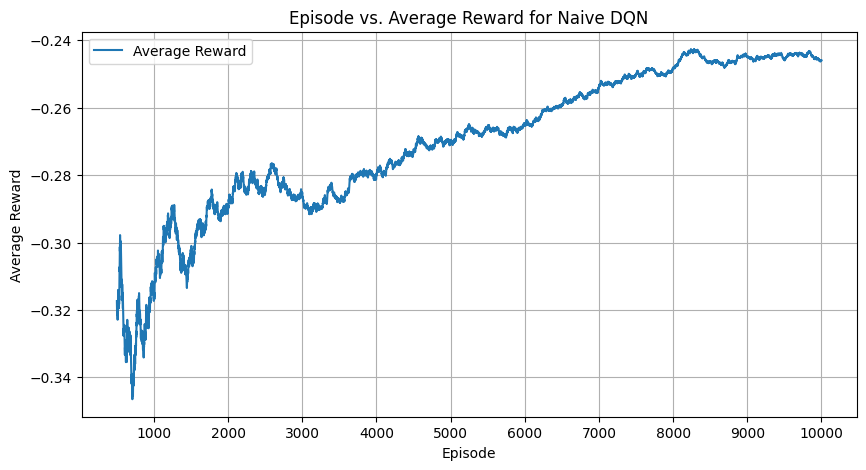

In [9]:
plot_rewards(ndqn_avg_rewards, 'Average Reward', 'Naive DQN')

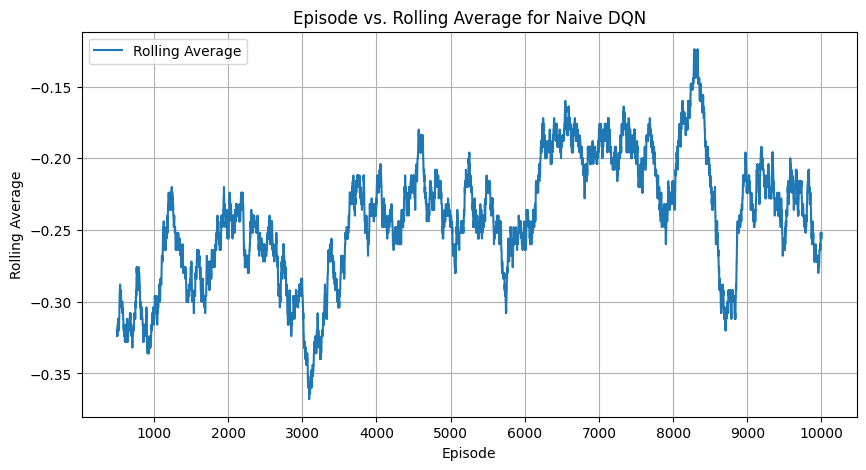

In [10]:
plot_rewards(ndqn_rolling_avgs, 'Rolling Average', 'Naive DQN')

###Double DQN

####Algorithm

In [11]:
import gymnasium as gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
from itertools import count

seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transition tuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# Implement replay memory from lecture
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

class DoubleDQNAgent:
    def __init__(self, env, batch_size=128, gamma=0.95, eps_start=0.95, eps_end=0.05, eps_decay=1000, lr=1e-4, target_update=10):
        self.env = env
        self.batch_size = batch_size
        self.gamma = gamma
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.lr = lr
        self.target_update = target_update
        self.steps_done = 0
        self.rewards_per_episode = []

        # Number of observations and actions (from the environment)
        n_observations = 2
        n_actions = env.action_space.n

        self.policy_net = DQN(n_observations, n_actions).to(device)
        self.target_net = DQN(n_observations, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.memory = ReplayMemory(10000)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1

        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32, device=device).view(1, 2)

        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1).indices.view(1, 1)
        else:
            return torch.tensor([[self.env.action_space.sample()]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([
            torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.next_state if s is not None
        ])
        state_batch = torch.cat([
            torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.state
        ])
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Double DQN: Select best action using policy_net, but evaluate with target_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            if len(non_final_next_states) > 0:
                best_actions = self.policy_net(non_final_next_states).max(1).indices.unsqueeze(1)
                next_state_values[non_final_mask] = self.target_net(non_final_next_states).gather(1, best_actions).squeeze()

        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, num_episodes):
        rewards = []
        avg_rewards = []
        rolling_avgs = []
        for i_episode in range(1, num_episodes+1):
            state = self.env.reset()
            total_reward = 0

            for t in count():
                action = self.select_action(state)
                next_state, reward, done, _ = self.env.step(action.item())
                total_reward += reward

                reward = torch.tensor([reward], dtype=torch.float32, device=device)
                if not done:
                    next_state = torch.tensor(next_state, dtype=torch.float32, device=device).view(1, 2)
                else:
                    next_state = None

                self.memory.push(state, action, next_state, reward)
                state = next_state if next_state is not None else state

                self.optimize_model()

                if done:
                    break

            rewards.append(total_reward)
            avg_rewards.append(sum(rewards) / len(rewards))
            if len(rewards) >= 500:
              rolling_avgs.append(sum(rewards[-500:])/500)
            else:
              rolling_avgs.append(sum(rewards)/len(rewards))
            if i_episode % 1000 == 0:
                print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}\tRolling average reward: {:.2f}'.format(
                  i_episode, total_reward, sum(rewards)/len(rewards), sum(rewards[-500:])/500))

            # Update target network periodically
            if i_episode % self.target_update == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return rewards, avg_rewards, rolling_avgs

####Hyperparameter Testing

In [222]:
learning_rates = [1e-3, 1e-4, 1e-5]
for lr in learning_rates:
  env = NaiveBlackJackEnv()
  agent = DoubleDQNAgent(env, batch_size=256, gamma=0.9, eps_start=0.95, eps_end=0.05, eps_decay=1000, lr=lr)
  rewards,_, _ = agent.train(2000)
  print('For lr {}, average reward = {}'.format(lr, sum(rewards)/len(rewards)))

<ipython-input-221-81a76a5de903>:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.next_state if s is not None
<ipython-input-221-81a76a5de903>:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.state


Episode 1000	Last reward: 1.00	Average reward: -0.36	Rolling average reward: -0.36
Episode 2000	Last reward: 1.00	Average reward: -0.30	Rolling average reward: -0.21
For lr 0.001, average reward = -0.303
Episode 1000	Last reward: 1.00	Average reward: -0.30	Rolling average reward: -0.25
Episode 2000	Last reward: -1.00	Average reward: -0.26	Rolling average reward: -0.24
For lr 0.0001, average reward = -0.261
Episode 1000	Last reward: -1.00	Average reward: -0.41	Rolling average reward: -0.37
Episode 2000	Last reward: -1.00	Average reward: -0.39	Rolling average reward: -0.30
For lr 1e-05, average reward = -0.387


In [223]:
#using previous results
batch_sizes = [128,256,512]
for batch_size in batch_sizes:
  env = NaiveBlackJackEnv()
  agent = DoubleDQNAgent(env, batch_size=batch_size, gamma=0.9, eps_start=0.95, eps_end=0.05, eps_decay=1000, lr= 1e-4)
  rewards,_, _ = agent.train(2000)
  print('For batch size {}, average reward = {}'.format(batch_size, sum(rewards)/len(rewards)))

<ipython-input-221-81a76a5de903>:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.next_state if s is not None
<ipython-input-221-81a76a5de903>:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.state


Episode 1000	Last reward: -1.00	Average reward: -0.34	Rolling average reward: -0.30
Episode 2000	Last reward: -1.00	Average reward: -0.25	Rolling average reward: -0.19
For batch size 128, average reward = -0.254
Episode 1000	Last reward: -1.00	Average reward: -0.33	Rolling average reward: -0.24
Episode 2000	Last reward: -1.00	Average reward: -0.27	Rolling average reward: -0.27
For batch size 256, average reward = -0.273
Episode 1000	Last reward: -1.00	Average reward: -0.40	Rolling average reward: -0.34
Episode 2000	Last reward: 1.00	Average reward: -0.32	Rolling average reward: -0.22
For batch size 512, average reward = -0.315


In [224]:
#using previous results
discount_factors = [0.9, 0.95, 0.99]
for gamma in discount_factors:
  env = NaiveBlackJackEnv()
  agent = NaiveDQNAgent(env, batch_size=128, gamma=gamma, eps_start=0.95, eps_end=0.05, eps_decay=1000, lr= 1e-4)
  rewards,_, _ = agent.train(2000)
  print('For gamma {}, average reward = {}'.format(gamma, sum(rewards)/len(rewards)))

<ipython-input-198-8644dda97317>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.next_state if s is not None
<ipython-input-198-8644dda97317>:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.state


Episode 1000	Last reward: -1.00	Average reward: -0.36	Rolling average reward: -0.34
Episode 2000	Last reward: 1.00	Average reward: -0.32	Rolling average reward: -0.28
For gamma 0.9, average reward = -0.319
Episode 1000	Last reward: 1.00	Average reward: -0.37	Rolling average reward: -0.31
Episode 2000	Last reward: -1.00	Average reward: -0.29	Rolling average reward: -0.18
For gamma 0.95, average reward = -0.292
Episode 1000	Last reward: -1.00	Average reward: -0.36	Rolling average reward: -0.26
Episode 2000	Last reward: -1.00	Average reward: -0.28	Rolling average reward: -0.18
For gamma 0.99, average reward = -0.275


In [226]:
#using previous results
eps_params = [(1.0, 0.1, 500), (0.9, 0.05, 1000), (0.95, 0.05, 2000)]
for eps_param in eps_params:
  env = NaiveBlackJackEnv()
  agent = DoubleDQNAgent(env, batch_size=128, gamma=0.99, eps_start=eps_param[0], eps_end=eps_param[1], eps_decay=eps_param[2], lr= 1e-4)
  rewards,_, _ = agent.train(2000)
  print('For eps params {}, average reward = {}'.format(eps_param, sum(rewards)/len(rewards)))

<ipython-input-221-81a76a5de903>:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.next_state if s is not None
<ipython-input-221-81a76a5de903>:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.state


Episode 1000	Last reward: 1.00	Average reward: -0.31	Rolling average reward: -0.22
Episode 2000	Last reward: -1.00	Average reward: -0.28	Rolling average reward: -0.27
For eps params (1.0, 0.1, 500), average reward = -0.28
Episode 1000	Last reward: -1.00	Average reward: -0.30	Rolling average reward: -0.20
Episode 2000	Last reward: -1.00	Average reward: -0.27	Rolling average reward: -0.25
For eps params (0.9, 0.05, 1000), average reward = -0.271
Episode 1000	Last reward: -1.00	Average reward: -0.38	Rolling average reward: -0.32
Episode 2000	Last reward: -1.00	Average reward: -0.32	Rolling average reward: -0.25
For eps params (0.95, 0.05, 2000), average reward = -0.321


####Hyperparameter Sensitivity Analysis

THe Double DQN model was not super sensitive to any of the hyperparameters, but when the learning rate was too small the training did learn too slowly. Similarly with the epsilon decay, a decay that is too slow has too much exploration, resulting in poorer performance as well.

####Model Training

In [12]:
# Create environment and agent
env = NaiveBlackJackEnv()
agent = DoubleDQNAgent(env, batch_size= 128, gamma= .99, eps_start= 0.9, eps_end= 0.05, eps_decay= 1000, lr= 1e-4)

# Train agent
num_episodes = 10000
ddqn_rewards, ddqn_avg_rewards, ddqn_rolling_avgs = agent.train(num_episodes)
print("Total Sum of Rewards:", sum(ddqn_rewards))

<ipython-input-11-81a76a5de903>:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.next_state if s is not None
<ipython-input-11-81a76a5de903>:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.state


Episode 1000	Last reward: 1.00	Average reward: -0.35	Rolling average reward: -0.33
Episode 2000	Last reward: 1.00	Average reward: -0.28	Rolling average reward: -0.25
Episode 3000	Last reward: 1.00	Average reward: -0.26	Rolling average reward: -0.19
Episode 4000	Last reward: -1.00	Average reward: -0.24	Rolling average reward: -0.20
Episode 5000	Last reward: -1.00	Average reward: -0.23	Rolling average reward: -0.24
Episode 6000	Last reward: -1.00	Average reward: -0.23	Rolling average reward: -0.21
Episode 7000	Last reward: 1.00	Average reward: -0.22	Rolling average reward: -0.20
Episode 8000	Last reward: -1.00	Average reward: -0.22	Rolling average reward: -0.20
Episode 9000	Last reward: 1.00	Average reward: -0.21	Rolling average reward: -0.22
Episode 10000	Last reward: -1.00	Average reward: -0.21	Rolling average reward: -0.16
Total Sum of Rewards: -2090


####Episode vs Reward Graphs

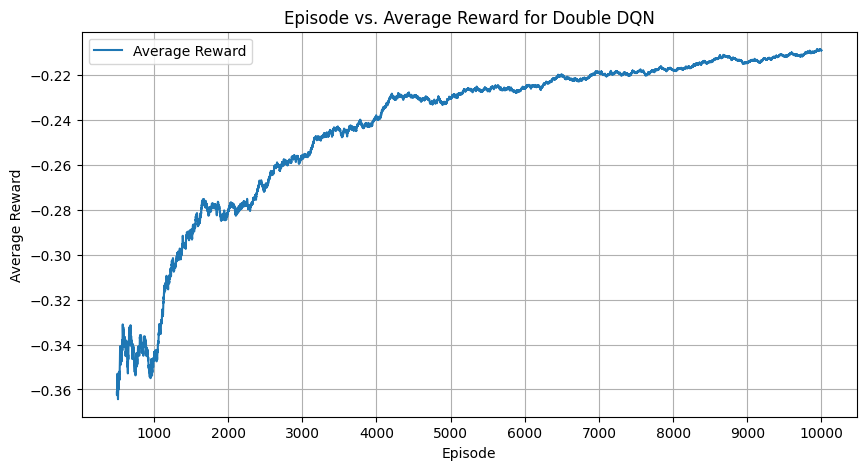

In [13]:
plot_rewards(ddqn_avg_rewards, 'Average Reward', 'Double DQN')

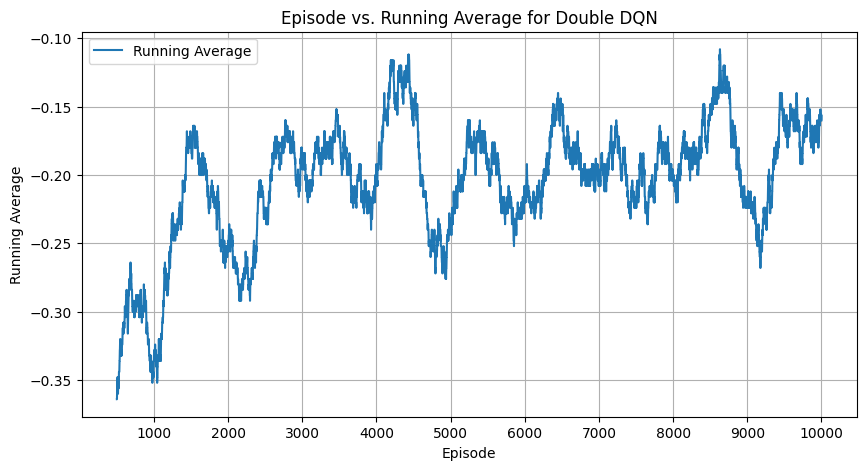

In [14]:
plot_rewards(ddqn_rolling_avgs, 'Running Average', 'Double DQN')

###Multi-Step Return DQN

####Algorithm

In [15]:
import gymnasium as gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
from itertools import count
import os

seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transition tuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# Implement replay memory from lecture but modify for multi step
class ReplayMemory:
    def __init__(self, capacity, n_steps, gamma):
        self.memory = deque([], maxlen=capacity)
        self.n_steps = n_steps
        self.gamma = gamma
        self.n_step_buffer = deque([], maxlen=n_steps)

    def push(self, *args):
        self.n_step_buffer.append(Transition(*args))

        if len(self.n_step_buffer) == self.n_steps:
            state, action = self.n_step_buffer[0].state, self.n_step_buffer[0].action
            reward, next_state = 0, None

            for i, transition in enumerate(self.n_step_buffer):
                reward += (self.gamma ** i) * transition.reward
                if transition.next_state is not None:
                    next_state = transition.next_state

            self.memory.append(Transition(state, action, next_state, torch.tensor([reward], dtype=torch.float32, device=device)))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


class MultiStepDQNAgent:
    def __init__(self, env, batch_size=256, gamma=0.9, n_steps=3, eps_start=0.95, eps_end=0.05, eps_decay=1000, lr=1e-4, target_update=10):
        self.env = env
        self.batch_size = batch_size
        self.gamma = gamma
        self.n_steps = n_steps
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.lr = lr
        self.target_update = target_update
        self.steps_done = 0
        self.rewards_per_episode = []

        # Number of observations and actions (from the environment)
        n_observations = 2
        n_actions = env.action_space.n

        self.policy_net = DQN(n_observations, n_actions).to(device)
        self.target_net = DQN(n_observations, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.memory = ReplayMemory(10000, n_steps, gamma)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1

        if not isinstance(state, torch.Tensor):  # Ensure `state` is a tensor
            state = torch.tensor(state, dtype=torch.float32, device=device).view(1, 2)

        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1).indices.view(1, 1)
        else:
            return torch.tensor([[self.env.action_space.sample()]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([
            torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.next_state if s is not None
        ])
        state_batch = torch.cat([
            torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.state
        ])
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Multi-step DQN: Compute Q-values with n-step return
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            if len(non_final_next_states) > 0:
                best_actions = self.policy_net(non_final_next_states).max(1).indices.unsqueeze(1)
                next_state_values[non_final_mask] = self.target_net(non_final_next_states).gather(1, best_actions).squeeze()

        expected_state_action_values = (next_state_values * (self.gamma ** self.n_steps)) + reward_batch

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, num_episodes):
        rewards = []
        avg_rewards = []
        rolling_avgs = []
        for i_episode in range(1, num_episodes+1):
            state = self.env.reset()
            total_reward = 0

            for t in count():
                action = self.select_action(state)
                next_state, reward, done, _ = self.env.step(action.item())
                total_reward += reward

                reward = torch.tensor([reward], dtype=torch.float32, device=device)
                if not done:
                    next_state = torch.tensor(next_state, dtype=torch.float32, device=device).view(1, 2)
                else:
                    next_state = None

                self.memory.push(state, action, next_state, reward)
                state = next_state if next_state is not None else state

                self.optimize_model()

                if done:
                    break

            rewards.append(total_reward)
            avg_rewards.append(sum(rewards) / len(rewards))
            if len(rewards) >= 500:
              rolling_avgs.append(sum(rewards[-500:])/500)
            else:
              rolling_avgs.append(sum(rewards)/len(rewards))
            if i_episode % 1000 == 0:
                print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}\tRolling average reward: {:.2f}'.format(
                  i_episode, total_reward, sum(rewards)/len(rewards), sum(rewards[-500:])/500))

            # Update target network periodically
            if i_episode % self.target_update == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

        return rewards, avg_rewards, rolling_avgs

####Hyperparameter Testing

In [181]:
learning_rates = [1e-3, 1e-4, 1e-5]
for lr in learning_rates:
  env = NaiveBlackJackEnv()
  agent = MultiStepDQNAgent(env, batch_size=256, gamma=0.9, n_steps=3, eps_start=0.95, eps_end=0.05, eps_decay=1000, lr=lr, target_update=10)
  rewards,_, _ = agent.train(2000)
  print('For lr {}, average reward = {}'.format(lr, sum(rewards)/len(rewards)))

<ipython-input-178-ec28a6613aa3>:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.next_state if s is not None
<ipython-input-178-ec28a6613aa3>:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.state


Episode 1000	Last reward: 1.00	Average reward: -0.30	Rolling average reward: -0.26
Episode 2000	Last reward: 1.00	Average reward: -0.23	Rolling average reward: -0.11
For lr 0.001, average reward = -0.231
Episode 1000	Last reward: -1.00	Average reward: -0.35	Rolling average reward: -0.28
Episode 2000	Last reward: -1.00	Average reward: -0.27	Rolling average reward: -0.25
For lr 0.0001, average reward = -0.265
Episode 1000	Last reward: 1.00	Average reward: -0.44	Rolling average reward: -0.45
Episode 2000	Last reward: -1.00	Average reward: -0.46	Rolling average reward: -0.51
For lr 1e-05, average reward = -0.458


In [184]:
#using previous results
batch_sizes = [128,256,512]
for batch_size in batch_sizes:
  env = NaiveBlackJackEnv()
  agent = MultiStepDQNAgent(env, batch_size=batch_size, gamma=0.9, n_steps=3, eps_start=0.95, eps_end=0.05, eps_decay=1000, lr= 1e-3, target_update=10)
  rewards,_, _ = agent.train(2000)
  print('For batch size {}, average reward = {}'.format(batch_size, sum(rewards)/len(rewards)))

<ipython-input-178-ec28a6613aa3>:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.next_state if s is not None
<ipython-input-178-ec28a6613aa3>:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.state


Episode 1000	Last reward: -1.00	Average reward: -0.31	Rolling average reward: -0.26
Episode 2000	Last reward: 1.00	Average reward: -0.26	Rolling average reward: -0.23
For batch size 128, average reward = -0.26
Episode 1000	Last reward: 1.00	Average reward: -0.37	Rolling average reward: -0.33
Episode 2000	Last reward: -1.00	Average reward: -0.31	Rolling average reward: -0.25
For batch size 256, average reward = -0.306
Episode 1000	Last reward: -1.00	Average reward: -0.36	Rolling average reward: -0.27
Episode 2000	Last reward: -1.00	Average reward: -0.29	Rolling average reward: -0.27
For batch size 512, average reward = -0.286


In [187]:
#using previous results
discount_factors = [0.9, 0.95, 0.99]
for gamma in discount_factors:
  env = NaiveBlackJackEnv()
  agent = MultiStepDQNAgent(env, batch_size=128, gamma=gamma, n_steps=3, eps_start=0.95, eps_end=0.05, eps_decay=1000, lr= 1e-3, target_update=10)
  rewards,_, _ = agent.train(2000)
  print('For gamma {}, average reward = {}'.format(gamma, sum(rewards)/len(rewards)))

<ipython-input-178-ec28a6613aa3>:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.next_state if s is not None
<ipython-input-178-ec28a6613aa3>:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.state


Episode 1000	Last reward: -1.00	Average reward: -0.42	Rolling average reward: -0.38
Episode 2000	Last reward: -1.00	Average reward: -0.29	Rolling average reward: -0.13
For gamma 0.9, average reward = -0.293
Episode 1000	Last reward: 1.00	Average reward: -0.37	Rolling average reward: -0.36
Episode 2000	Last reward: -1.00	Average reward: -0.43	Rolling average reward: -0.47
For gamma 0.95, average reward = -0.431
Episode 1000	Last reward: -1.00	Average reward: -0.43	Rolling average reward: -0.40
Episode 2000	Last reward: 1.00	Average reward: -0.43	Rolling average reward: -0.42
For gamma 0.99, average reward = -0.426


In [189]:
#using previous results
eps_params = [(1.0, 0.1, 500), (0.9, 0.05, 1000), (0.95, 0.05, 2000)]
for eps_param in eps_params:
  env = NaiveBlackJackEnv()
  agent = MultiStepDQNAgent(env, batch_size=128, gamma=0.9, n_steps=3, eps_start=eps_param[0], eps_end=eps_param[1], eps_decay=eps_param[2], lr= 1e-3, target_update=10)
  rewards,_, _ = agent.train(2000)
  print('For eps params {}, average reward = {}'.format(eps_param, sum(rewards)/len(rewards)))

<ipython-input-178-ec28a6613aa3>:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.next_state if s is not None
<ipython-input-178-ec28a6613aa3>:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.state


Episode 1000	Last reward: -1.00	Average reward: -0.31	Rolling average reward: -0.27
Episode 2000	Last reward: -1.00	Average reward: -0.27	Rolling average reward: -0.24
For eps params (1.0, 0.1, 500), average reward = -0.27
Episode 1000	Last reward: -1.00	Average reward: -0.36	Rolling average reward: -0.28
Episode 2000	Last reward: -1.00	Average reward: -0.29	Rolling average reward: -0.22
For eps params (0.9, 0.05, 1000), average reward = -0.293
Episode 1000	Last reward: 1.00	Average reward: -0.38	Rolling average reward: -0.34
Episode 2000	Last reward: 1.00	Average reward: -0.32	Rolling average reward: -0.22
For eps params (0.95, 0.05, 2000), average reward = -0.318


In [191]:
#using previous results
n_steps = [3,4,5]
for steps in n_steps:
  env = NaiveBlackJackEnv()
  agent = MultiStepDQNAgent(env, batch_size=128, gamma=.9, n_steps=steps, eps_start=1.0, eps_end=0.1, eps_decay=500, lr= 1e-3, target_update=10)
  rewards,_, _ = agent.train(2000)
  print('For n_steps {}, average reward = {}'.format(steps, sum(rewards)/len(rewards)))

<ipython-input-178-ec28a6613aa3>:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.next_state if s is not None
<ipython-input-178-ec28a6613aa3>:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.state


Episode 1000	Last reward: 1.00	Average reward: -0.27	Rolling average reward: -0.21
Episode 2000	Last reward: 1.00	Average reward: -0.23	Rolling average reward: -0.18
For n_steps 3, average reward = -0.227
Episode 1000	Last reward: -1.00	Average reward: -0.33	Rolling average reward: -0.24
Episode 2000	Last reward: -1.00	Average reward: -0.28	Rolling average reward: -0.25
For n_steps 4, average reward = -0.284
Episode 1000	Last reward: -1.00	Average reward: -0.25	Rolling average reward: -0.17
Episode 2000	Last reward: -1.00	Average reward: -0.24	Rolling average reward: -0.26
For n_steps 5, average reward = -0.242


####Hyperparameter Sensitivity Analysis

Multi Step DQN was most sensitive to the discount factor, which makes sense since we are also considering other rewards in the algorithm. I would also imagine the the number of steps would be significant as well, but since I picked a pretty small range of values, it didn't have much of an effect. The reason I picked a small range was because most blackjack games don't go beyond 5 cards

####Model Training

In [16]:
# Create environment and agent
env = NaiveBlackJackEnv()
agent = MultiStepDQNAgent(env, batch_size= 128, gamma= .9, n_steps=3, eps_start= 1.0, eps_end= 0.1, eps_decay= 500, lr=1e-3)

# Train the agent
num_episodes = 10000
multi_dqn_rewards, multi_dqn_avg_rewards, multi_dqn_rolling_avgs = agent.train(num_episodes)
print("Total Sum of Rewards:", sum(multi_dqn_rewards))

<ipython-input-15-ec28a6613aa3>:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.next_state if s is not None
<ipython-input-15-ec28a6613aa3>:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s, dtype=torch.float32, device=device).view(1, 2) for s in batch.state


Episode 1000	Last reward: -1.00	Average reward: -0.31	Rolling average reward: -0.22
Episode 2000	Last reward: -1.00	Average reward: -0.29	Rolling average reward: -0.27
Episode 3000	Last reward: 1.00	Average reward: -0.27	Rolling average reward: -0.30
Episode 4000	Last reward: -1.00	Average reward: -0.27	Rolling average reward: -0.30
Episode 5000	Last reward: -1.00	Average reward: -0.26	Rolling average reward: -0.20
Episode 6000	Last reward: 1.00	Average reward: -0.26	Rolling average reward: -0.21
Episode 7000	Last reward: -1.00	Average reward: -0.25	Rolling average reward: -0.18
Episode 8000	Last reward: -1.00	Average reward: -0.24	Rolling average reward: -0.20
Episode 9000	Last reward: -1.00	Average reward: -0.24	Rolling average reward: -0.19
Episode 10000	Last reward: -1.00	Average reward: -0.23	Rolling average reward: -0.23
Total Sum of Rewards: -2344


####Episode vs Reward Graphs

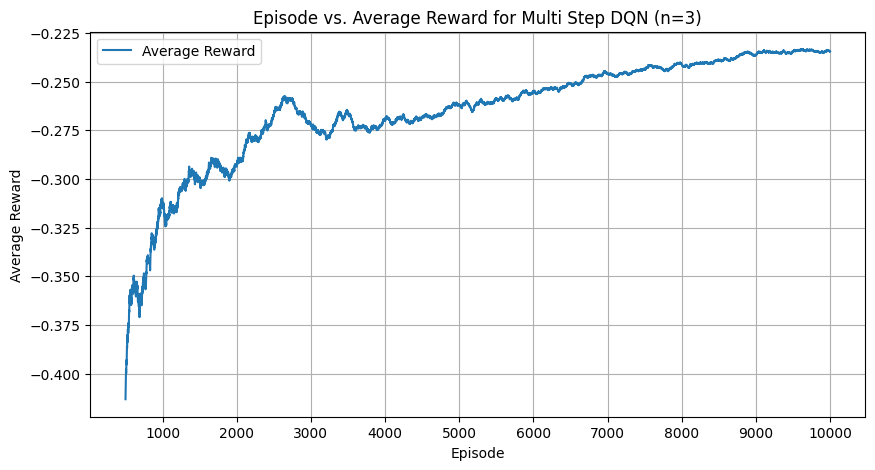

In [17]:
plot_rewards(multi_dqn_avg_rewards, 'Average Reward', 'Multi Step DQN (n=3)')

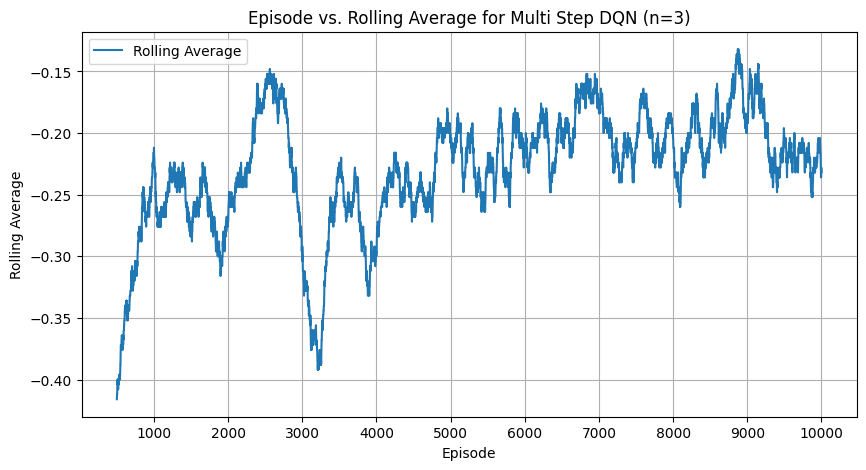

In [18]:
plot_rewards(multi_dqn_rolling_avgs, 'Rolling Average', 'Multi Step DQN (n=3)')

###Comparison

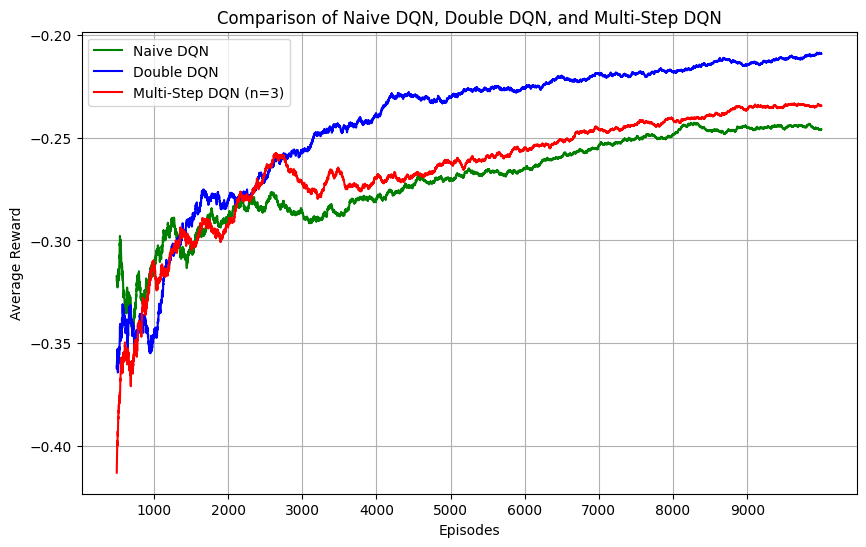

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Removing first 500 points to eliminate beginning phase on graph and plotting
plt.plot(range(500, 500 + len(ndqn_avg_rewards[500:])), ndqn_avg_rewards[500:], label='Naive DQN', color='green')
plt.plot(range(500, 500 + len(ddqn_avg_rewards[500:])), ddqn_avg_rewards[500:], label='Double DQN', color='blue')
plt.plot(range(500, 500 + len(multi_dqn_avg_rewards[500:])), multi_dqn_avg_rewards[500:], label='Multi-Step DQN (n=3)', color='red')

# Labeling plot and setting ticks
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.title("Comparison of Naive DQN, Double DQN, and Multi-Step DQN")
xticks = range(1000, 500 + len(ndqn_avg_rewards[500:]), 1000)
plt.xticks(xticks)

plt.legend()
plt.grid()
plt.show()


Since the rolling averages don't have smooth graphs, it would be hard to compare the performances with all of the variation. So, I decided to fit a logarithmic curve to the result to visluaize it better

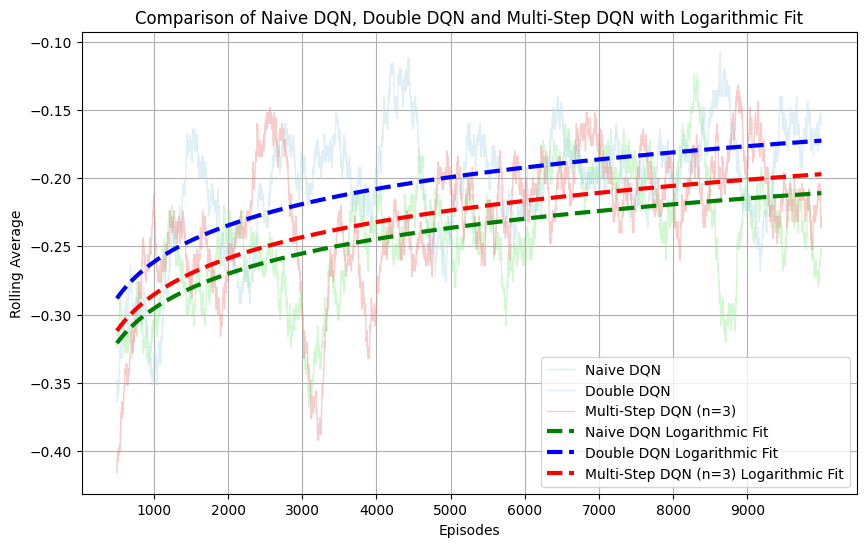

In [304]:
import numpy as np
import matplotlib.pyplot as plt

x_range = range(500, 500 + len(ndqn_rolling_avgs[500:])) # Setting x-range

def logarithmic_fit(x, y): # Fitting log function
    log_x = np.log(x)
    p = np.polyfit(log_x, y, 1)
    return p

#Fitting all of the models
p_ndqn = logarithmic_fit(x_range, ndqn_rolling_avgs[500:])
fitted_ndqn = np.polyval(p_ndqn, np.log(x_range))

p_ddqn = logarithmic_fit(x_range, ddqn_rolling_avgs[500:])
fitted_ddqn = np.polyval(p_ddqn, np.log(x_range))

p_multi_dqn = logarithmic_fit(x_range, multi_dqn_rolling_avgs[500:])
fitted_multi_dqn = np.polyval(p_multi_dqn, np.log(x_range))

plt.figure(figsize=(10, 6))

# Plotting rolling averages in the background with a lighter color
plt.plot(x_range, ndqn_rolling_avgs[500:], label='Naive DQN', color='lightgreen', alpha=0.4, linewidth=1)
plt.plot(x_range, ddqn_rolling_avgs[500:], label='Double DQN', color='lightblue', alpha=0.4, linewidth=1)
plt.plot(x_range, multi_dqn_rolling_avgs[500:], label='Multi-Step DQN (n=3)', color='lightcoral', alpha=0.4, linewidth=1)

# Plotting the logarithmic regression lines with bolder colors
plt.plot(x_range, fitted_ndqn, '--', label='Naive DQN Logarithmic Fit', color='green', linewidth=3)
plt.plot(x_range, fitted_ddqn, '--', label='Double DQN Logarithmic Fit', color='blue', linewidth=3)
plt.plot(x_range, fitted_multi_dqn, '--', label='Multi-Step DQN (n=3) Logarithmic Fit', color='red', linewidth=3)

# Labeling and setting ticks
plt.xlabel("Episodes")
plt.ylabel("Rolling Average")
plt.title("Comparison of Naive DQN, Double DQN and Multi-Step DQN with Logarithmic Fit")
xticks = range(1000, 500 + len(ndqn_rolling_avgs[500:]), 1000)
plt.xticks(xticks)

plt.legend()
plt.grid()
plt.show()


####AUC Comparison

*See comparison at bottom of notebook*

##Problem 3: Implementing Policy Gradient Methods

###REINFORCE

####Algorithm

Here, we define the parts of the algorithm but do not run training yet, so we can optimize our hyperparameters first

In [231]:
import gymnasium as gym
import numpy as np
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


# REINFORCE Policy
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(2, 128)  # Two observations: total without aces, number of aces
        self.affine2 = nn.Linear(128, 2)  # Two possible actions: Hit or Stand
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = self.affine1(x)
        x = F.relu(x)
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

# Function for selecting actions based on the policy
def select_action(state):
    state_tensor = torch.tensor(np.array(state), dtype=torch.float32).unsqueeze(0)
    probs = policy(state_tensor)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_log_probs.append(m.log_prob(action))
    return action.item()

# Function to finish an episode, compute gradients, and update the policy
def finish_episode(policy, optimizer, gamma, eps=np.finfo(np.float32).eps.item()):
    R = 0
    policy_loss = []
    returns = deque()
    for r in reversed(policy.rewards):
        R = r + gamma * R
        returns.appendleft(R)

    if len(returns) > 0:
        returns = torch.tensor(list(returns), dtype=torch.float32)
        if returns.std() > 0:
            returns = (returns - returns.mean()) / (returns.std() + eps)
        for log_prob, R in zip(policy.saved_log_probs, returns):
            policy_loss.append(-log_prob * R)
        optimizer.zero_grad()
        loss = torch.cat(policy_loss).sum()
        loss.backward()
        optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]

####Hyperparameter Tuning

In [232]:
env = env = gym.make('Blackjack-v1')
learning_rates = [1e-3, 1e-4, 1e-5]

# 1. Tune Learning Rate
for lr in learning_rates:
    print(f"Testing Learning Rate: {lr}")

    policy = Policy()
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    rewards = []
    avg_rewards = []
    rolling_avgs = []
    episode_batch = []

    for i_episode in range(1, 10001):
      observation, _ = env.reset()
      state = (observation[0], int(observation[2]))
      total_reward = 0

      for t in count(1):
          action = select_action(state)
          next_observation, reward, terminated, truncated, _ = env.step(action)
          done = terminated or truncated
          next_state = (next_observation[0], int(next_observation[2]))
          policy.rewards.append(reward)
          total_reward += reward
          state = next_state
          if done:
              break

      rewards.append(total_reward)
      episode_batch.append(total_reward)

      # Only update the policy after accumulating batch
      if len(episode_batch) >= 128:
          finish_episode(policy, optimizer, gamma=0.95)
          episode_batch = []

      avg_reward = np.mean(rewards)
      avg_rewards.append(avg_reward)
      if len(rewards) >= 500:
          rolling_avg = np.mean(rewards[-500:])
      else:
          rolling_avg = np.mean(rewards)
      rolling_avgs.append(rolling_avg)

      if i_episode % 1000 == 0:
          print(f'Learning rate: {lr}, Episode {i_episode}\tLast reward: {total_reward:.2f}\tAverage reward: {avg_reward:.2f}\tRolling average: {rolling_avg:.2f}')

    print(f'Total sum of rewards: {sum(rewards)}')

Testing Learning Rate: 0.001
Learning rate: 0.001, Episode 1000	Last reward: 1.00	Average reward: -0.62	Rolling average: -0.42
Learning rate: 0.001, Episode 2000	Last reward: -1.00	Average reward: -0.38	Rolling average: -0.04
Learning rate: 0.001, Episode 3000	Last reward: 1.00	Average reward: -0.31	Rolling average: -0.17
Learning rate: 0.001, Episode 4000	Last reward: 1.00	Average reward: -0.28	Rolling average: -0.11
Learning rate: 0.001, Episode 5000	Last reward: 1.00	Average reward: -0.27	Rolling average: -0.27
Learning rate: 0.001, Episode 6000	Last reward: -1.00	Average reward: -0.26	Rolling average: -0.22
Learning rate: 0.001, Episode 7000	Last reward: -1.00	Average reward: -0.24	Rolling average: -0.14
Learning rate: 0.001, Episode 8000	Last reward: -1.00	Average reward: -0.24	Rolling average: -0.20
Learning rate: 0.001, Episode 9000	Last reward: -1.00	Average reward: -0.23	Rolling average: -0.17
Learning rate: 0.001, Episode 10000	Last reward: -1.00	Average reward: -0.22	Rolling

In [240]:
# 2. Tune Batch Size (fix the best learning rate found)
env = env = gym.make('Blackjack-v1')
batch_sizes = [128, 256, 512]

for batch_size in batch_sizes:
    print(f"Testing Batch Size: {batch_size}")
    policy = Policy()
    optimizer = optim.Adam(policy.parameters(), lr=1e-4)

    gamma = 0.95

    rewards = []
    avg_rewards = []
    rolling_avgs = []
    episode_batch = []

    for i_episode in range(1, 10001):
      observation, _ = env.reset()
      state = (observation[0], int(observation[2]))
      total_reward = 0

      for t in count(1):
          action = select_action(state)
          next_observation, reward, terminated, truncated, _ = env.step(action)
          done = terminated or truncated
          next_state = (next_observation[0], int(next_observation[2]))
          policy.rewards.append(reward)
          total_reward += reward
          state = next_state
          if done:
              break

      rewards.append(total_reward)
      episode_batch.append(total_reward)

      # Only update the policy after accumulating batch
      if len(episode_batch) >= batch_size:
          finish_episode(policy, optimizer, gamma)
          episode_batch = []

      avg_reward = np.mean(rewards)
      avg_rewards.append(avg_reward)
      if len(rewards) >= 500:
          rolling_avg = np.mean(rewards[-500:])
      else:
          rolling_avg = np.mean(rewards)
      rolling_avgs.append(rolling_avg)

      if i_episode % 1000 == 0:
          print(f'Batch size: {lr}, Episode {i_episode}\tLast reward: {total_reward:.2f}\tAverage reward: {avg_reward:.2f}\tRolling average: {rolling_avg:.2f}')

    print(f'Total sum of rewards: {sum(rewards)}')

Testing Batch Size: 128
Batch size: 1e-05, Episode 1000	Last reward: 1.00	Average reward: -0.14	Rolling average: -0.17
Batch size: 1e-05, Episode 2000	Last reward: -1.00	Average reward: -0.16	Rolling average: -0.16
Batch size: 1e-05, Episode 3000	Last reward: -1.00	Average reward: -0.16	Rolling average: -0.15
Batch size: 1e-05, Episode 4000	Last reward: -1.00	Average reward: -0.16	Rolling average: -0.14
Batch size: 1e-05, Episode 5000	Last reward: 1.00	Average reward: -0.17	Rolling average: -0.27
Batch size: 1e-05, Episode 6000	Last reward: 1.00	Average reward: -0.18	Rolling average: -0.24
Batch size: 1e-05, Episode 7000	Last reward: 1.00	Average reward: -0.19	Rolling average: -0.28
Batch size: 1e-05, Episode 8000	Last reward: -1.00	Average reward: -0.19	Rolling average: -0.11
Batch size: 1e-05, Episode 9000	Last reward: -1.00	Average reward: -0.19	Rolling average: -0.15
Batch size: 1e-05, Episode 10000	Last reward: -1.00	Average reward: -0.19	Rolling average: -0.20
Total sum of reward

In [242]:
env = gym.make('Blackjack-v1')
discount_factors = [0.9, 0.95, 0.99]
# 3. Tune Discount Factor (fix the best batch size and learning rate found)
for gamma_val in discount_factors:
    print(f"Testing Discount Factor: {gamma_val}")
    policy = Policy()
    optimizer = optim.Adam(policy.parameters(), lr=1e-4)

    gamma = gamma_val
    batch_size = 256

    rewards = []
    avg_rewards = []
    rolling_avgs = []
    episode_batch = []

    for i_episode in range(1, 10001):
      observation, _ = env.reset()
      state = (observation[0], int(observation[2]))
      total_reward = 0

      for t in count(1):
          action = select_action(state)
          next_observation, reward, terminated, truncated, _ = env.step(action)
          done = terminated or truncated
          next_state = (next_observation[0], int(next_observation[2]))
          policy.rewards.append(reward)
          total_reward += reward
          state = next_state
          if done:
              break

      rewards.append(total_reward)
      episode_batch.append(total_reward)

      # Only update the policy after accumulating batch
      if len(episode_batch) >= batch_size:
          finish_episode(policy, optimizer, gamma)
          episode_batch = []

      avg_reward = np.mean(rewards)
      avg_rewards.append(avg_reward)
      if len(rewards) >= 500:
          rolling_avg = np.mean(rewards[-500:])
      else:
          rolling_avg = np.mean(rewards)
      rolling_avgs.append(rolling_avg)

      if i_episode % 1000 == 0:
          print(f'Gamma: {lr}, Episode {i_episode}\tLast reward: {total_reward:.2f}\tAverage reward: {avg_reward:.2f}\tRolling average: {rolling_avg:.2f}')

    print(f'Total sum of rewards: {sum(rewards)}')

Testing Discount Factor: 0.9
Gamma: 1e-05, Episode 1000	Last reward: -1.00	Average reward: -0.26	Rolling average: -0.25
Gamma: 1e-05, Episode 2000	Last reward: 1.00	Average reward: -0.24	Rolling average: -0.25
Gamma: 1e-05, Episode 3000	Last reward: 1.00	Average reward: -0.22	Rolling average: -0.17
Gamma: 1e-05, Episode 4000	Last reward: -1.00	Average reward: -0.21	Rolling average: -0.20
Gamma: 1e-05, Episode 5000	Last reward: 1.00	Average reward: -0.20	Rolling average: -0.18
Gamma: 1e-05, Episode 6000	Last reward: 0.00	Average reward: -0.19	Rolling average: -0.11
Gamma: 1e-05, Episode 7000	Last reward: -1.00	Average reward: -0.19	Rolling average: -0.24
Gamma: 1e-05, Episode 8000	Last reward: -1.00	Average reward: -0.18	Rolling average: -0.15
Gamma: 1e-05, Episode 9000	Last reward: -1.00	Average reward: -0.18	Rolling average: -0.12
Gamma: 1e-05, Episode 10000	Last reward: 1.00	Average reward: -0.19	Rolling average: -0.19
Total sum of rewards: -1879.0
Testing Discount Factor: 0.95
Gamma

####Hyperparameter Sensitivity Analysis

The learning rate seemed to have the greatest variance based on performance, but generally the hyperparameters we not too sensitive.

####Model Training

In [250]:
env = gym.make('Blackjack-v1')
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-4) #lr from results

# Lists for statistics
reinforce_rewards = []       # Episode rewards
reinforce_avg_rewards = []   # Average reward over all episodes so far
reinforce_rolling_avgs = []  # Rolling average over the last 500 episodes
episode_batch = []

gamma = .99
batch_size = 256

for i_episode in range(1, 10001):
  observation, _ = env.reset()
  state = (observation[0], int(observation[2]))
  total_reward = 0

  for t in count(1):
      action = select_action(state)
      next_observation, reward, terminated, truncated, _ = env.step(action)
      done = terminated or truncated
      next_state = (next_observation[0], int(next_observation[2]))
      policy.rewards.append(reward)
      total_reward += reward
      state = next_state
      if done:
          break

  reinforce_rewards.append(total_reward)
  episode_batch.append(total_reward)

  # Only update the policy after accumulating batch
  if len(episode_batch) >= batch_size:
      finish_episode(policy, optimizer, gamma)
      episode_batch = []

  avg_reward = np.mean(reinforce_rewards)
  reinforce_avg_rewards.append(avg_reward)
  rolling_avg = np.mean(reinforce_rewards[-500:]) if len(reinforce_rewards) >= 500 else avg_reward
  reinforce_rolling_avgs.append(rolling_avg)

  if i_episode % 1000 == 0:
    print(f'Episode {i_episode}\tLast reward: {total_reward:.2f}\tAverage reward: {avg_reward:.2f}\tRolling average: {rolling_avg:.2f}')


Episode 1000	Last reward: 1.00	Average reward: -0.21	Rolling average: -0.22
Episode 2000	Last reward: -1.00	Average reward: -0.19	Rolling average: -0.16
Episode 3000	Last reward: -1.00	Average reward: -0.19	Rolling average: -0.17
Episode 4000	Last reward: 1.00	Average reward: -0.20	Rolling average: -0.23
Episode 5000	Last reward: -1.00	Average reward: -0.21	Rolling average: -0.18
Episode 6000	Last reward: -1.00	Average reward: -0.20	Rolling average: -0.21
Episode 7000	Last reward: -1.00	Average reward: -0.21	Rolling average: -0.18
Episode 8000	Last reward: -1.00	Average reward: -0.20	Rolling average: -0.17
Episode 9000	Last reward: -1.00	Average reward: -0.19	Rolling average: -0.12
Episode 10000	Last reward: 1.00	Average reward: -0.19	Rolling average: -0.17


In [251]:
print(sum(reinforce_rewards))

-1906.0


####Episode vs Reward Graphs

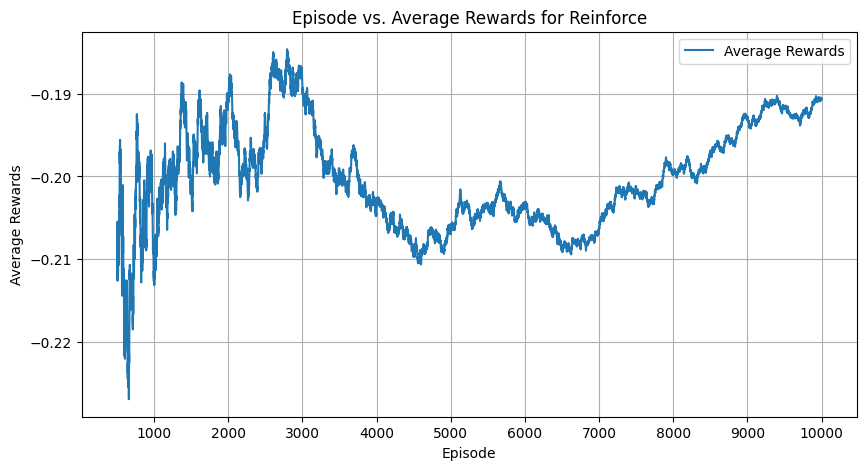

In [252]:
plot_rewards(reinforce_avg_rewards, 'Average Rewards', 'Reinforce')

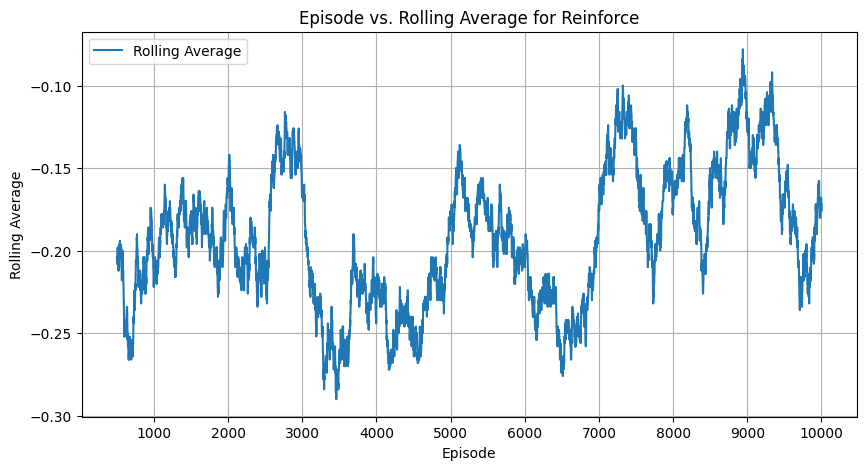

In [253]:
plot_rewards(reinforce_rolling_avgs, 'Rolling Average', 'Reinforce')

###TRPO

####Algorithm

In [203]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from collections import deque
from itertools import count

env = gym.make('Blackjack-v1')

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(2, 128)
        self.affine2 = nn.Linear(128, 2)
        self.saved_log_probs = []
        self.rewards = []
        self.saved_states = []  # Stores states for KL divergence check

    def forward(self, x):
        x = F.relu(self.affine1(x))
        return F.softmax(self.affine2(x), dim=1)

policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-4)
eps = np.finfo(np.float32).eps.item()

def select_action(state):
    state_tensor = torch.tensor(np.array(state), dtype=torch.float32).unsqueeze(0)
    probs = policy(state_tensor)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_log_probs.append(m.log_prob(action))
    policy.saved_states.append(state)
    return action.item()

def compute_fisher_information():
    if not policy.saved_log_probs:
        total_params = sum(p.numel() for p in policy.parameters())
        return torch.zeros((total_params, total_params))

    total_params = sum(p.numel() for p in policy.parameters())
    fisher_matrix = torch.zeros((total_params, total_params))

    for log_prob in policy.saved_log_probs:
        grads = torch.autograd.grad(log_prob, policy.parameters(), retain_graph=True)
        grads_flat = torch.cat([g.view(-1) for g in grads])
        fisher_matrix += torch.outer(grads_flat, grads_flat)

    fisher_matrix /= len(policy.saved_log_probs)
    fisher_matrix += torch.eye(total_params) * 1e-3  # Regularization
    return fisher_matrix

def compute_natural_gradient(policy_gradient):
    fisher_matrix = compute_fisher_information()
    fisher_inv = torch.linalg.inv(fisher_matrix)
    return fisher_inv @ policy_gradient.detach()

def compute_kl_divergence(old_probs, new_probs):
    kl_divergence = torch.sum(old_probs * (torch.log(old_probs) - torch.log(new_probs)))
    return kl_divergence

def finish_batch(gamma, max_kl_divergence):
    if len(policy.rewards) == 0:
        policy.rewards.clear()
        policy.saved_log_probs.clear()
        policy.saved_states.clear()
        return

    R = 0
    returns = deque()
    for r in reversed(policy.rewards):
        R = r + gamma * R
        returns.appendleft(R)

    returns = torch.tensor(returns, dtype=torch.float32)
    if returns.std() > 0:
        returns = (returns - returns.mean()) / (returns.std() + eps)

    total_params = sum(p.numel() for p in policy.parameters())
    policy_gradient = torch.zeros(total_params)

    for log_prob, R in zip(policy.saved_log_probs, returns):
        loss = -log_prob * R
        grads = torch.autograd.grad(loss, policy.parameters(), retain_graph=True)
        grads_flat = torch.cat([g.view(-1) for g in grads])
        policy_gradient += grads_flat

    old_probs = []
    for state in policy.saved_states:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            prob = policy(state_tensor)
        old_probs.append(prob)

    natural_gradient = compute_natural_gradient(policy_gradient)

    with torch.no_grad():
        idx = 0
        for param in policy.parameters():
            param_size = param.numel()
            param.grad = natural_gradient[idx: idx + param_size].view(param.shape)
            idx += param_size

    optimizer.step()

    new_probs = []
    for state in policy.saved_states:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            prob = policy(state_tensor)
        new_probs.append(prob)

    kl_div = 0.0
    for old, new in zip(old_probs, new_probs):
        kl_div += compute_kl_divergence(old, new)

    if kl_div > max_kl_divergence:
        scale = torch.sqrt(max_kl_divergence / kl_div)
        with torch.no_grad():
            for param in policy.parameters():
                param.grad *= scale
        optimizer.step()

    policy.rewards.clear()
    policy.saved_log_probs.clear()
    policy.saved_states.clear()

####Hyperparameter Tuning

In [209]:
env = gym.make('Blackjack-v1')
learning_rates = [1e-3, 1e-4, 1e-5]

# 1. Tune Learning Rate
for lr in learning_rates:
  print(f"Testing Learning Rate: {lr}")

  policy = Policy()
  optimizer = optim.Adam(policy.parameters(), lr=lr)
  eps = np.finfo(np.float32).eps.item()

  max_kl_divergence = .01
  gamma = .9
  batch_size = 128

  trpo_rewards = []
  episode_batch = []

  for i_episode in range(1, 10001):
      observation, _ = env.reset()
      state = (observation[0], int(observation[2]))
      total_reward = 0

      for t in count(1):
          action = select_action(state)
          next_observation, reward, terminated, truncated, _ = env.step(action)
          done = terminated or truncated
          next_state = (next_observation[0], int(next_observation[2]))
          policy.rewards.append(reward)
          total_reward += reward
          state = next_state
          if done:
              break

      trpo_rewards.append(total_reward)
      episode_batch.append(total_reward)

      if len(episode_batch) >= batch_size:
          finish_batch(policy, optimizer, gamma, max_kl_divergence)
          episode_batch = []

      avg_reward = np.mean(trpo_rewards)

      if len(trpo_rewards) >= 500:
          rolling_avg = np.mean(trpo_rewards[-500:])
      else:
          rolling_avg = np.mean(trpo_rewards)

      if i_episode % 1000 == 0:
          print(f'Learning rate: {lr}, Episode {i_episode}\tLast reward: {total_reward:.2f}\tAverage reward: {avg_reward:.2f}\tRolling average: {rolling_avg:.2f}')

  print(sum(trpo_rewards))


Testing Learning Rate: 0.001
Learning rate: 0.001, Episode 1000	Last reward: 1.00	Average reward: -0.18	Rolling average: -0.20
Learning rate: 0.001, Episode 2000	Last reward: -1.00	Average reward: -0.20	Rolling average: -0.23
Learning rate: 0.001, Episode 3000	Last reward: -1.00	Average reward: -0.19	Rolling average: -0.14
Learning rate: 0.001, Episode 4000	Last reward: 1.00	Average reward: -0.18	Rolling average: -0.13
Learning rate: 0.001, Episode 5000	Last reward: 1.00	Average reward: -0.16	Rolling average: -0.12
Learning rate: 0.001, Episode 6000	Last reward: -1.00	Average reward: -0.16	Rolling average: -0.12
Learning rate: 0.001, Episode 7000	Last reward: -1.00	Average reward: -0.16	Rolling average: -0.20
Learning rate: 0.001, Episode 8000	Last reward: 1.00	Average reward: -0.16	Rolling average: -0.12
Learning rate: 0.001, Episode 9000	Last reward: -1.00	Average reward: -0.17	Rolling average: -0.20
Learning rate: 0.001, Episode 10000	Last reward: 1.00	Average reward: -0.17	Rolling 

In [219]:
# 2. Tune Batch Size (fix the best learning rate found)
env = gym.make('Blackjack-v1')
batch_sizes = [128, 256, 512]

for batch_size in batch_sizes:
    print(f"Testing Batch Size: {batch_size}")

    policy = Policy()
    optimizer = optim.Adam(policy.parameters(), lr=1e-3)
    eps = np.finfo(np.float32).eps.item()

    max_kl_divergence = .01
    gamma = .9

    trpo_rewards = []
    episode_batch = []

    for i_episode in range(1, 10001):
      observation, _ = env.reset()
      state = (observation[0], int(observation[2]))
      total_reward = 0

      for t in count(1):
          action = select_action(state)
          next_observation, reward, terminated, truncated, _ = env.step(action)
          done = terminated or truncated
          next_state = (next_observation[0], int(next_observation[2]))
          policy.rewards.append(reward)
          total_reward += reward
          state = next_state
          if done:
              break

      trpo_rewards.append(total_reward)
      episode_batch.append(total_reward)

      if len(episode_batch) >= batch_size:
          finish_batch(policy, optimizer, gamma, max_kl_divergence)
          episode_batch = []

      avg_reward = np.mean(trpo_rewards)

      if len(trpo_rewards) >= 500:
          rolling_avg = np.mean(trpo_rewards[-500:])
      else:
          rolling_avg = np.mean(trpo_rewards)

      if i_episode % 1000 == 0:
            print(f'Batch size: {batch_size}, Episode {i_episode}\tLast reward: {total_reward:.2f}\tAverage reward: {avg_reward:.2f}\tRolling average: {rolling_avg:.2f}')

    print(sum(trpo_rewards))


Testing Batch Size: 128
Batch size: 128, Episode 1000	Last reward: -1.00	Average reward: -0.15	Rolling average: -0.19
Batch size: 128, Episode 2000	Last reward: 0.00	Average reward: -0.20	Rolling average: -0.23
Batch size: 128, Episode 3000	Last reward: -1.00	Average reward: -0.20	Rolling average: -0.25
Batch size: 128, Episode 4000	Last reward: -1.00	Average reward: -0.20	Rolling average: -0.19
Batch size: 128, Episode 5000	Last reward: 1.00	Average reward: -0.17	Rolling average: -0.05
Batch size: 128, Episode 6000	Last reward: 1.00	Average reward: -0.17	Rolling average: -0.16
Batch size: 128, Episode 7000	Last reward: -1.00	Average reward: -0.17	Rolling average: -0.18
Batch size: 128, Episode 8000	Last reward: -1.00	Average reward: -0.18	Rolling average: -0.20
Batch size: 128, Episode 9000	Last reward: 1.00	Average reward: -0.17	Rolling average: -0.17
Batch size: 128, Episode 10000	Last reward: 1.00	Average reward: -0.18	Rolling average: -0.29
-1782.0
Testing Batch Size: 256
Batch si

In [224]:
env = gym.make('Blackjack-v1')
discount_factors = [0.9, 0.95, 0.99]

# 3. Tune Discount Factor (fix the best batch size and learning rate found)
for gamma_val in discount_factors:
    print(f"Testing Discount Factor: {gamma_val}")

    policy = Policy()
    optimizer = optim.Adam(policy.parameters(), lr=1e-3)
    eps = np.finfo(np.float32).eps.item()

    max_kl_divergence = .01
    gamma = gamma_val
    batch_size = 128

    # Training loop
    trpo_rewards = []
    episode_batch = []

    for i_episode in range(1, 10001):
      observation, _ = env.reset()
      state = (observation[0], int(observation[2]))
      total_reward = 0

      for t in count(1):
          action = select_action(state)
          next_observation, reward, terminated, truncated, _ = env.step(action)
          done = terminated or truncated
          next_state = (next_observation[0], int(next_observation[2]))
          policy.rewards.append(reward)
          total_reward += reward
          state = next_state
          if done:
              break

      trpo_rewards.append(total_reward)
      episode_batch.append(total_reward)

      if len(episode_batch) >= batch_size:
          finish_batch(policy, optimizer, gamma, max_kl_divergence)
          episode_batch = []

      avg_reward = np.mean(trpo_rewards)

      if len(trpo_rewards) >= 500:
          rolling_avg = np.mean(trpo_rewards[-500:])
      else:
          rolling_avg = np.mean(trpo_rewards)

      if i_episode % 1000 == 0:
            print(f'Discount factor: {batch_size}, Episode {i_episode}\tLast reward: {total_reward:.2f}\tAverage reward: {avg_reward:.2f}\tRolling average: {rolling_avg:.2f}')

    print(sum(trpo_rewards))

Testing Discount Factor: 0.9
Discount factor: 128, Episode 1000	Last reward: 1.00	Average reward: -0.14	Rolling average: -0.12
Discount factor: 128, Episode 2000	Last reward: -1.00	Average reward: -0.15	Rolling average: -0.14
Discount factor: 128, Episode 3000	Last reward: -1.00	Average reward: -0.15	Rolling average: -0.13
Discount factor: 128, Episode 4000	Last reward: 1.00	Average reward: -0.15	Rolling average: -0.19
Discount factor: 128, Episode 5000	Last reward: -1.00	Average reward: -0.16	Rolling average: -0.24
Discount factor: 128, Episode 6000	Last reward: 1.00	Average reward: -0.16	Rolling average: -0.08
Discount factor: 128, Episode 7000	Last reward: -1.00	Average reward: -0.16	Rolling average: -0.11
Discount factor: 128, Episode 8000	Last reward: 0.00	Average reward: -0.17	Rolling average: -0.19
Discount factor: 128, Episode 9000	Last reward: 1.00	Average reward: -0.17	Rolling average: -0.18
Discount factor: 128, Episode 10000	Last reward: -1.00	Average reward: -0.17	Rolling 

In [226]:
env = gym.make('Blackjack-v1')
kl_thresholds = [0.01, 0.1, 0.5]
# 4. Tune kl_thresholds (fix the best gamma, batch size, and learning rate found)
for kl in kl_thresholds:
    print(f"Testing KL Threshold: {kl}")

    policy = Policy()
    optimizer = optim.Adam(policy.parameters(), lr=1e-3)
    eps = np.finfo(np.float32).eps.item()

    max_kl_divergence = kl
    gamma = 0.9
    batch_size = 128

    trpo_rewards = []
    episode_batch = []

    for i_episode in range(1, 10001):
      observation, _ = env.reset()
      state = (observation[0], int(observation[2]))
      total_reward = 0

      for t in count(1):
          action = select_action(state)
          next_observation, reward, terminated, truncated, _ = env.step(action)
          done = terminated or truncated
          next_state = (next_observation[0], int(next_observation[2]))
          policy.rewards.append(reward)
          total_reward += reward
          state = next_state
          if done:
              break

      trpo_rewards.append(total_reward)
      episode_batch.append(total_reward)

      if len(episode_batch) >= batch_size:
          finish_batch(policy, optimizer, gamma, max_kl_divergence)
          episode_batch = []

      avg_reward = np.mean(trpo_rewards)

      if len(trpo_rewards) >= 500:
          rolling_avg = np.mean(trpo_rewards[-500:])
      else:
          rolling_avg = np.mean(trpo_rewards)

      if i_episode % 1000 == 0:
            print(f'KL threshold: {batch_size}, Episode {i_episode}\tLast reward: {total_reward:.2f}\tAverage reward: {avg_reward:.2f}\tRolling average: {rolling_avg:.2f}')

    print(sum(trpo_rewards))

Testing KL Threshold: 0.01
KL threshold: 128, Episode 1000	Last reward: -1.00	Average reward: -0.18	Rolling average: -0.21
KL threshold: 128, Episode 2000	Last reward: 1.00	Average reward: -0.18	Rolling average: -0.19
KL threshold: 128, Episode 3000	Last reward: -1.00	Average reward: -0.18	Rolling average: -0.21
KL threshold: 128, Episode 4000	Last reward: -1.00	Average reward: -0.17	Rolling average: -0.12
KL threshold: 128, Episode 5000	Last reward: -1.00	Average reward: -0.17	Rolling average: -0.17
KL threshold: 128, Episode 6000	Last reward: -1.00	Average reward: -0.18	Rolling average: -0.22
KL threshold: 128, Episode 7000	Last reward: 1.00	Average reward: -0.18	Rolling average: -0.14
KL threshold: 128, Episode 8000	Last reward: -1.00	Average reward: -0.18	Rolling average: -0.27
KL threshold: 128, Episode 9000	Last reward: -1.00	Average reward: -0.18	Rolling average: -0.14
KL threshold: 128, Episode 10000	Last reward: -1.00	Average reward: -0.18	Rolling average: -0.16
-1795.0
Testin

####Hyperparameter Sensitivity Analysis

The batch size was very sensitive for the TRPO model, because when the batch got too large, proper training updates did not occur. This resulted in the algorithm ultimately diverging. The discount factor was also very sensitive, most likely due to the fact that heavily weighting future rewards can lead to us potentially busting more often (more risky moves)

####Model Training

In [230]:
env = gym.make('Blackjack-v1')
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-4)
eps = np.finfo(np.float32).eps.item()

max_kl_divergence = .01
gamma = 0.9
batch_size = 128

trpo_rewards = []
trpo_avg_rewards = []
trpo_rolling_avgs = []
episode_batch = []

for i_episode in range(1, 10001):
  observation, _ = env.reset()
  state = (observation[0], int(observation[2]))
  total_reward = 0

  for t in count(1):
      action = select_action(state)
      next_observation, reward, terminated, truncated, _ = env.step(action)
      done = terminated or truncated
      next_state = (next_observation[0], int(next_observation[2]))
      policy.rewards.append(reward)
      total_reward += reward
      state = next_state
      if done:
          break

  trpo_rewards.append(total_reward)
  episode_batch.append(total_reward)

  if len(episode_batch) >= batch_size:
      finish_batch(policy, optimizer, gamma, max_kl_divergence)
      episode_batch = []

  avg_reward = np.mean(trpo_rewards)
  trpo_avg_rewards.append(avg_reward)

  if len(trpo_rewards) >= 500:
      rolling_avg = np.mean(trpo_rewards[-500:])
  else:
      rolling_avg = np.mean(trpo_rewards)

  trpo_rolling_avgs.append(rolling_avg)

  if i_episode % 1000 == 0:
        print(f'KL threshold: {batch_size}, Episode {i_episode}\tLast reward: {total_reward:.2f}\tAverage reward: {avg_reward:.2f}\tRolling average: {rolling_avg:.2f}')

print(sum(trpo_rewards))

KL threshold: 128, Episode 1000	Last reward: 1.00	Average reward: -0.19	Rolling average: -0.21
KL threshold: 128, Episode 2000	Last reward: 1.00	Average reward: -0.22	Rolling average: -0.25
KL threshold: 128, Episode 3000	Last reward: -1.00	Average reward: -0.20	Rolling average: -0.16
KL threshold: 128, Episode 4000	Last reward: -1.00	Average reward: -0.20	Rolling average: -0.13
KL threshold: 128, Episode 5000	Last reward: -1.00	Average reward: -0.18	Rolling average: -0.11
KL threshold: 128, Episode 6000	Last reward: -1.00	Average reward: -0.20	Rolling average: -0.24
KL threshold: 128, Episode 7000	Last reward: 1.00	Average reward: -0.19	Rolling average: -0.14
KL threshold: 128, Episode 8000	Last reward: -1.00	Average reward: -0.18	Rolling average: -0.16
KL threshold: 128, Episode 9000	Last reward: 1.00	Average reward: -0.18	Rolling average: -0.18
KL threshold: 128, Episode 10000	Last reward: 1.00	Average reward: -0.18	Rolling average: -0.14
-1785.0


####Episode vs Reward Graphs

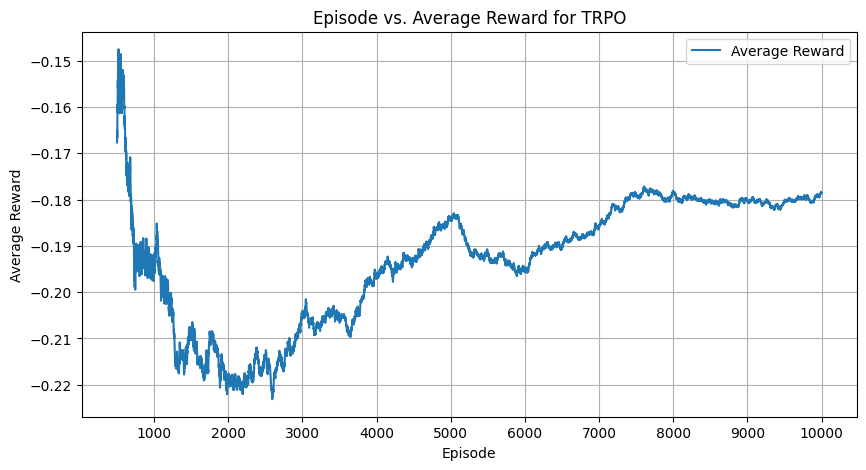

In [254]:
plot_rewards(trpo_avg_rewards, 'Average Reward', 'TRPO')

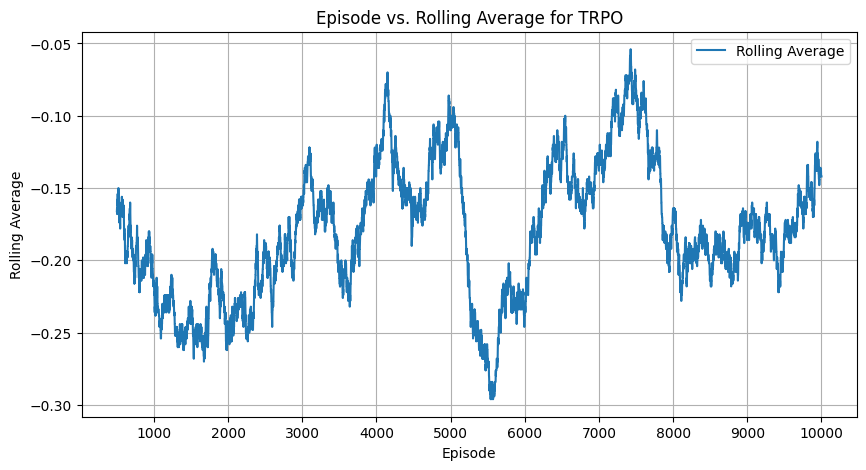

In [255]:
plot_rewards(trpo_rolling_avgs, 'Rolling Average', 'TRPO')

###PPO

####Algorithm

In [258]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from collections import deque
from itertools import count

# Actor-Critic Model
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.actor = nn.Linear(128, 2)  # Two possible actions: Hit or Stand
        self.critic = nn.Linear(128, 1)  # State value estimator

    def forward(self, x):
        x = F.relu(self.fc1(x))
        probs = F.softmax(self.actor(x), dim=-1)
        value = self.critic(x)
        return probs, value

def select_action(state, saved_log_probs, values, policy):
    state_tensor = torch.tensor(np.array(state, dtype=np.float32), dtype=torch.float32).unsqueeze(0)
    probs, value = policy(state_tensor)
    m = Categorical(probs)
    action = m.sample()

    saved_log_probs.append(m.log_prob(action))
    values.append(value.detach())
    return action.item()

def finish_batch(saved_log_probs, rewards, values, policy, optimizer, gamma, kl_threshold, clip_epsilon):
    R = 0
    returns = deque()
    for r in reversed(rewards):
        R = r + gamma * R
        returns.appendleft(R)

    if len(returns) == 0:
        return

    returns = torch.tensor(list(returns), dtype=torch.float32)
    values_tensor = torch.cat(values).squeeze()
    advantages = returns - values_tensor.detach()

    # Compute PPO ratio
    log_probs = torch.stack(saved_log_probs)
    old_log_probs = log_probs.detach()
    ratio = torch.exp(log_probs - old_log_probs)

    # PPO Clipping
    clipped_ratio = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon)
    policy_loss = -torch.min(ratio * advantages, clipped_ratio * advantages).mean()

    # KL Divergence Regularization
    with torch.no_grad():
        kl_div = (old_log_probs - log_probs).mean().item()
    if kl_div > kl_threshold:
        return

    # Total loss: Policy + Value loss
    value_loss = 0.5 * (advantages.pow(2)).mean()
    loss = policy_loss + value_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

####Hyperparameter Tuning

In [261]:
env = gym.make('Blackjack-v1')
learning_rates = [1e-3, 1e-4, 1e-5]

# 1. Tune Learning Rate

for lr in learning_rates:
    print(f"Testing Learning Rate: {lr}")

    policy = ActorCritic()
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    clip_epsilon = 0.2  # PPO clip parameter
    gamma = 0.99
    kl_threshold = 0.01
    batch_size = 128

    ppo_rewards = []
    episode_batch = []

    for i_episode in range(1, 10001):
      observation, _ = env.reset()
      state = (observation[0], int(observation[2]))
      total_reward = 0
      saved_log_probs = []
      values = []
      rewards = []

      for t in count(1):
          action = select_action(state, saved_log_probs, values, policy)
          next_observation, reward, terminated, truncated, _ = env.step(action)
          done = terminated or truncated
          next_state = (next_observation[0], int(next_observation[2]))
          rewards.append(reward)
          total_reward += reward
          state = next_state
          if done:
              break

      ppo_rewards.append(total_reward)
      episode_batch.append(total_reward)

      if len(episode_batch) >= batch_size:
          finish_batch(saved_log_probs, rewards, values, policy, optimizer, gamma, kl_threshold, clip_epsilon)
          episode_batch = []

      avg_reward = np.mean(ppo_rewards)
      rolling_avg = np.mean(ppo_rewards[-500:]) if len(ppo_rewards) >= 500 else avg_reward

      if i_episode % 1000 == 0:
          print(f'Episode {i_episode}\tLast reward: {total_reward:.2f}\tAverage reward: {avg_reward:.2f}\tRolling average: {rolling_avg:.2f}')

    print(sum(ppo_rewards))

Testing Learning Rate: 0.001
Episode 1000	Last reward: -1.00	Average reward: -0.32	Rolling average: -0.25
Episode 2000	Last reward: -1.00	Average reward: -0.24	Rolling average: -0.17
Episode 3000	Last reward: 1.00	Average reward: -0.23	Rolling average: -0.15
Episode 4000	Last reward: -1.00	Average reward: -0.22	Rolling average: -0.17
Episode 5000	Last reward: -1.00	Average reward: -0.22	Rolling average: -0.22
Episode 6000	Last reward: 0.00	Average reward: -0.22	Rolling average: -0.23
Episode 7000	Last reward: -1.00	Average reward: -0.21	Rolling average: -0.17
Episode 8000	Last reward: 1.00	Average reward: -0.21	Rolling average: -0.22
Episode 9000	Last reward: -1.00	Average reward: -0.21	Rolling average: -0.21
Episode 10000	Last reward: 0.00	Average reward: -0.22	Rolling average: -0.31
-2167.0
Testing Learning Rate: 0.0001
Episode 1000	Last reward: 1.00	Average reward: -0.20	Rolling average: -0.23
Episode 2000	Last reward: -1.00	Average reward: -0.18	Rolling average: -0.18
Episode 3000	

In [267]:
env = gym.make('Blackjack-v1')
batch_sizes = [128, 256, 512]

# 2. Tune Batch Size (fix the best learning rate found)
for batch_size in batch_sizes:
    print(f"Testing Batch Size: {batch_size}")

    policy = ActorCritic()
    optimizer = optim.Adam(policy.parameters(), lr=1e-4)

    clip_epsilon = 0.2
    gamma = 0.99
    kl_threshold = 0.01
    batch_size = batch_size

    ppo_rewards = []
    episode_batch = []

    for i_episode in range(1, 10001):
      observation, _ = env.reset()
      state = (observation[0], int(observation[2]))
      total_reward = 0
      saved_log_probs = []
      values = []
      rewards = []

      for t in count(1):
          action = select_action(state, saved_log_probs, values, policy)
          next_observation, reward, terminated, truncated, _ = env.step(action)
          done = terminated or truncated
          next_state = (next_observation[0], int(next_observation[2]))
          rewards.append(reward)
          total_reward += reward
          state = next_state
          if done:
              break

      ppo_rewards.append(total_reward)
      episode_batch.append(total_reward)

      if len(episode_batch) >= batch_size:
          finish_batch(saved_log_probs, rewards, values, policy, optimizer, gamma, kl_threshold, clip_epsilon)
          episode_batch = []

      avg_reward = np.mean(ppo_rewards)
      rolling_avg = np.mean(ppo_rewards[-500:]) if len(ppo_rewards) >= 500 else avg_reward

      if i_episode % 1000 == 0:
          print(f'Episode {i_episode}\tLast reward: {total_reward:.2f}\tAverage reward: {avg_reward:.2f}\tRolling average: {rolling_avg:.2f}')

    print(sum(ppo_rewards))

Testing Batch Size: 128
Episode 1000	Last reward: 1.00	Average reward: -0.21	Rolling average: -0.19
Episode 2000	Last reward: -1.00	Average reward: -0.19	Rolling average: -0.18
Episode 3000	Last reward: -1.00	Average reward: -0.20	Rolling average: -0.19
Episode 4000	Last reward: 1.00	Average reward: -0.21	Rolling average: -0.20
Episode 5000	Last reward: -1.00	Average reward: -0.21	Rolling average: -0.27
Episode 6000	Last reward: 1.00	Average reward: -0.20	Rolling average: -0.21
Episode 7000	Last reward: 1.00	Average reward: -0.20	Rolling average: -0.17
Episode 8000	Last reward: 1.00	Average reward: -0.20	Rolling average: -0.18
Episode 9000	Last reward: 1.00	Average reward: -0.20	Rolling average: -0.13
Episode 10000	Last reward: -1.00	Average reward: -0.19	Rolling average: -0.15
-1913.0
Testing Batch Size: 256
Episode 1000	Last reward: -1.00	Average reward: -0.21	Rolling average: -0.24
Episode 2000	Last reward: -1.00	Average reward: -0.18	Rolling average: -0.18
Episode 3000	Last reward:

In [269]:
env = gym.make('Blackjack-v1')
discount_factors = [0.9, 0.95, 0.99]

# 3. Tune Discount Factor (fix the best batch size and learning rate found)
for gamma_val in discount_factors:
    print(f"Testing Discount Factor: {gamma_val}")

    policy = ActorCritic()
    optimizer = optim.Adam(policy.parameters(), lr=1e-4)

    clip_epsilon = 0.2
    gamma = gamma
    kl_threshold = 0.01
    batch_size = 512

    ppo_rewards = []
    episode_batch = []

    for i_episode in range(1, 10001):
      observation, _ = env.reset()
      state = (observation[0], int(observation[2]))
      total_reward = 0
      saved_log_probs = []
      values = []
      rewards = []

      for t in count(1):
          action = select_action(state, saved_log_probs, values, policy)
          next_observation, reward, terminated, truncated, _ = env.step(action)
          done = terminated or truncated
          next_state = (next_observation[0], int(next_observation[2]))
          rewards.append(reward)
          total_reward += reward
          state = next_state
          if done:
              break

      ppo_rewards.append(total_reward)
      episode_batch.append(total_reward)

      if len(episode_batch) >= batch_size:
          finish_batch(saved_log_probs, rewards, values, policy, optimizer, gamma, kl_threshold, clip_epsilon)
          episode_batch = []

      avg_reward = np.mean(ppo_rewards)
      rolling_avg = np.mean(ppo_rewards[-500:]) if len(ppo_rewards) >= 500 else avg_reward

      if i_episode % 1000 == 0:
          print(f'Episode {i_episode}\tLast reward: {total_reward:.2f}\tAverage reward: {avg_reward:.2f}\tRolling average: {rolling_avg:.2f}')

    print(sum(ppo_rewards))

Testing Discount Factor: 0.9
Episode 1000	Last reward: -1.00	Average reward: -0.32	Rolling average: -0.29
Episode 2000	Last reward: 0.00	Average reward: -0.31	Rolling average: -0.32
Episode 3000	Last reward: -1.00	Average reward: -0.31	Rolling average: -0.33
Episode 4000	Last reward: -1.00	Average reward: -0.31	Rolling average: -0.35
Episode 5000	Last reward: 1.00	Average reward: -0.29	Rolling average: -0.22
Episode 6000	Last reward: -1.00	Average reward: -0.28	Rolling average: -0.20
Episode 7000	Last reward: 1.00	Average reward: -0.28	Rolling average: -0.28
Episode 8000	Last reward: 1.00	Average reward: -0.28	Rolling average: -0.29
Episode 9000	Last reward: 1.00	Average reward: -0.27	Rolling average: -0.24
Episode 10000	Last reward: -1.00	Average reward: -0.27	Rolling average: -0.21
-2667.0
Testing Discount Factor: 0.95
Episode 1000	Last reward: -1.00	Average reward: -0.19	Rolling average: -0.21
Episode 2000	Last reward: 1.00	Average reward: -0.20	Rolling average: -0.24
Episode 3000	L

In [271]:
env = gym.make('Blackjack-v1')
kl_thresholds = [0.01, 0.1, 0.5]
# 4. Tune kl_thresholds (fix the best gamma, batch size, and learning rate found)
for kl in kl_thresholds:
    print(f"Testing KL Threshold: {kl}")

    policy = ActorCritic()
    optimizer = optim.Adam(policy.parameters(), lr=1e-4)

    clip_epsilon = 0.2
    gamma = 0.99
    kl_threshold = kl
    batch_size = 512

    ppo_rewards = []
    episode_batch = []

    for i_episode in range(1, 10001):
      observation, _ = env.reset()
      state = (observation[0], int(observation[2]))
      total_reward = 0
      saved_log_probs = []
      values = []
      rewards = []

      for t in count(1):
          action = select_action(state, saved_log_probs, values, policy)
          next_observation, reward, terminated, truncated, _ = env.step(action)
          done = terminated or truncated
          next_state = (next_observation[0], int(next_observation[2]))
          rewards.append(reward)
          total_reward += reward
          state = next_state
          if done:
              break

      ppo_rewards.append(total_reward)
      episode_batch.append(total_reward)

      if len(episode_batch) >= batch_size:
          finish_batch(saved_log_probs, rewards, values, policy, optimizer, gamma, kl_threshold, clip_epsilon)
          episode_batch = []

      avg_reward = np.mean(ppo_rewards)
      rolling_avg = np.mean(ppo_rewards[-500:]) if len(ppo_rewards) >= 500 else avg_reward

      if i_episode % 1000 == 0:
          print(f'Episode {i_episode}\tLast reward: {total_reward:.2f}\tAverage reward: {avg_reward:.2f}\tRolling average: {rolling_avg:.2f}')

    print(sum(ppo_rewards))

Testing KL Threshold: 0.01
Episode 1000	Last reward: 1.00	Average reward: -0.18	Rolling average: -0.19
Episode 2000	Last reward: -1.00	Average reward: -0.19	Rolling average: -0.22
Episode 3000	Last reward: 1.00	Average reward: -0.16	Rolling average: -0.11
Episode 4000	Last reward: -1.00	Average reward: -0.16	Rolling average: -0.21
Episode 5000	Last reward: 0.00	Average reward: -0.17	Rolling average: -0.21
Episode 6000	Last reward: -1.00	Average reward: -0.18	Rolling average: -0.21
Episode 7000	Last reward: 1.00	Average reward: -0.18	Rolling average: -0.23
Episode 8000	Last reward: -1.00	Average reward: -0.17	Rolling average: -0.12
Episode 9000	Last reward: -1.00	Average reward: -0.17	Rolling average: -0.17
Episode 10000	Last reward: -1.00	Average reward: -0.18	Rolling average: -0.28
-1772.0
Testing KL Threshold: 0.1
Episode 1000	Last reward: 1.00	Average reward: -0.19	Rolling average: -0.21
Episode 2000	Last reward: 0.00	Average reward: -0.19	Rolling average: -0.17
Episode 3000	Last re

In [277]:
env = gym.make('Blackjack-v1')
clippings = [0.1, 0.2, 0.3]
# 5. Tune Clipping Factors (fix the best kl threshold, gamma, batch size, and learning rate found)
for clip in clippings:
    print(f"Testing Clipping Factor: {clip}")

    policy = ActorCritic()
    optimizer = optim.Adam(policy.parameters(), lr=1e-4)

    clip_epsilon = clip
    gamma = 0.99
    kl_threshold = 0.01
    batch_size = 512

    ppo_rewards = []
    episode_batch = []

    for i_episode in range(1, 10001):
      observation, _ = env.reset()
      state = (observation[0], int(observation[2]))
      total_reward = 0
      saved_log_probs = []
      values = []
      rewards = []

      for t in count(1):
          action = select_action(state, saved_log_probs, values, policy)
          next_observation, reward, terminated, truncated, _ = env.step(action)
          done = terminated or truncated
          next_state = (next_observation[0], int(next_observation[2]))
          rewards.append(reward)
          total_reward += reward
          state = next_state
          if done:
              break

      ppo_rewards.append(total_reward)
      episode_batch.append(total_reward)

      if len(episode_batch) >= batch_size:
          finish_batch(saved_log_probs, rewards, values, policy, optimizer, gamma, kl_threshold, clip_epsilon)
          episode_batch = []

      avg_reward = np.mean(ppo_rewards)
      rolling_avg = np.mean(ppo_rewards[-500:]) if len(ppo_rewards) >= 500 else avg_reward

      if i_episode % 1000 == 0:
          print(f'Episode {i_episode}\tLast reward: {total_reward:.2f}\tAverage reward: {avg_reward:.2f}\tRolling average: {rolling_avg:.2f}')

    print(sum(ppo_rewards))

Testing Clipping Factor: 0.1
Episode 1000	Last reward: -1.00	Average reward: -0.86	Rolling average: -0.84
Episode 2000	Last reward: 1.00	Average reward: -0.83	Rolling average: -0.81
Episode 3000	Last reward: 0.00	Average reward: -0.83	Rolling average: -0.82
Episode 4000	Last reward: -1.00	Average reward: -0.81	Rolling average: -0.78
Episode 5000	Last reward: -1.00	Average reward: -0.79	Rolling average: -0.64
Episode 6000	Last reward: -1.00	Average reward: -0.78	Rolling average: -0.76
Episode 7000	Last reward: -1.00	Average reward: -0.78	Rolling average: -0.74
Episode 8000	Last reward: -1.00	Average reward: -0.77	Rolling average: -0.73
Episode 9000	Last reward: -1.00	Average reward: -0.77	Rolling average: -0.69
Episode 10000	Last reward: -1.00	Average reward: -0.76	Rolling average: -0.74
-7639.0
Testing Clipping Factor: 0.2
Episode 1000	Last reward: -1.00	Average reward: -0.13	Rolling average: -0.16
Episode 2000	Last reward: -1.00	Average reward: -0.17	Rolling average: -0.23
Episode 300

####Hyperparameter Sensitivity Analysis

The learning rate and the kl threshold were sensitive hyperparameters, with a small learning rate or high kl threshold stopping learning. However, the clipping factor showed the most sensitivity, with a value of 0.2 producing the only good results

####Model Training

In [289]:
env = gym.make('Blackjack-v1')
policy = ActorCritic()
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Hyperparameters
clip_epsilon = 0.2
gamma = 0.95
kl_threshold = 0.01
batch_size = 512

ppo_rewards = []
ppo_avg_rewards = []
ppo_rolling_avgs = []
episode_batch = []

for i_episode in range(1, 10001):
    observation, _ = env.reset()
    state = (observation[0], int(observation[2]))
    total_reward = 0
    saved_log_probs = []
    values = []
    rewards = []

    for t in count(1):
        action = select_action(state, saved_log_probs, values, policy)
        next_observation, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state = (next_observation[0], int(next_observation[2]))
        rewards.append(reward)
        total_reward += reward
        state = next_state
        if done:
            break

    ppo_rewards.append(total_reward)
    episode_batch.append(total_reward)

    if len(episode_batch) >= batch_size:
        finish_batch(saved_log_probs, rewards, values, policy, optimizer, gamma, kl_threshold, clip_epsilon)
        episode_batch = []

    avg_reward = np.mean(ppo_rewards)
    ppo_avg_rewards.append(avg_reward)

    rolling_avg = np.mean(ppo_rewards[-500:]) if len(ppo_rewards) >= 500 else avg_reward
    ppo_rolling_avgs.append(rolling_avg)

    if i_episode % 1000 == 0:
        print(f'Episode {i_episode}\tLast reward: {total_reward:.2f}\tAverage reward: {avg_reward:.2f}\tRolling average: {rolling_avg:.2f}')

print(sum(ppo_rewards))

Episode 1000	Last reward: 0.00	Average reward: -0.18	Rolling average: -0.20
Episode 2000	Last reward: -1.00	Average reward: -0.17	Rolling average: -0.15
Episode 3000	Last reward: -1.00	Average reward: -0.18	Rolling average: -0.21
Episode 4000	Last reward: -1.00	Average reward: -0.19	Rolling average: -0.15
Episode 5000	Last reward: 1.00	Average reward: -0.19	Rolling average: -0.20
Episode 6000	Last reward: 0.00	Average reward: -0.18	Rolling average: -0.14
Episode 7000	Last reward: 1.00	Average reward: -0.18	Rolling average: -0.12
Episode 8000	Last reward: 1.00	Average reward: -0.17	Rolling average: -0.12
Episode 9000	Last reward: -1.00	Average reward: -0.17	Rolling average: -0.14
Episode 10000	Last reward: 0.00	Average reward: -0.18	Rolling average: -0.19
-1764.0


####Episode vs Reward Graphs

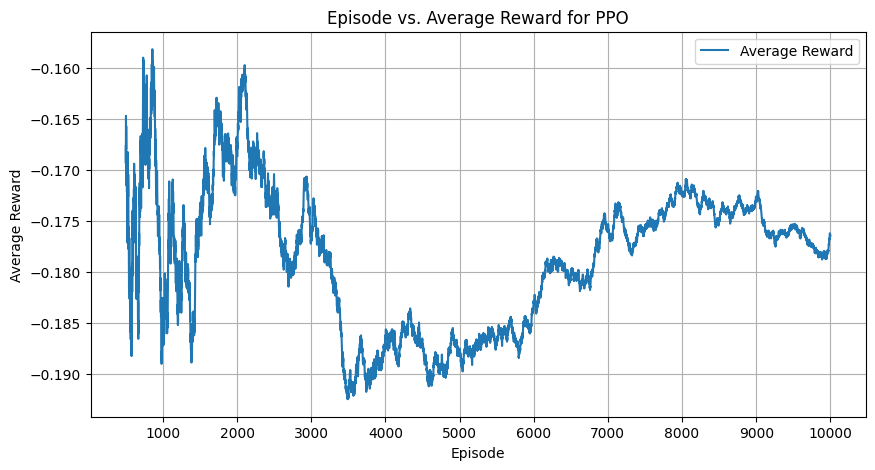

In [290]:
plot_rewards(ppo_avg_rewards, 'Average Reward', 'PPO')

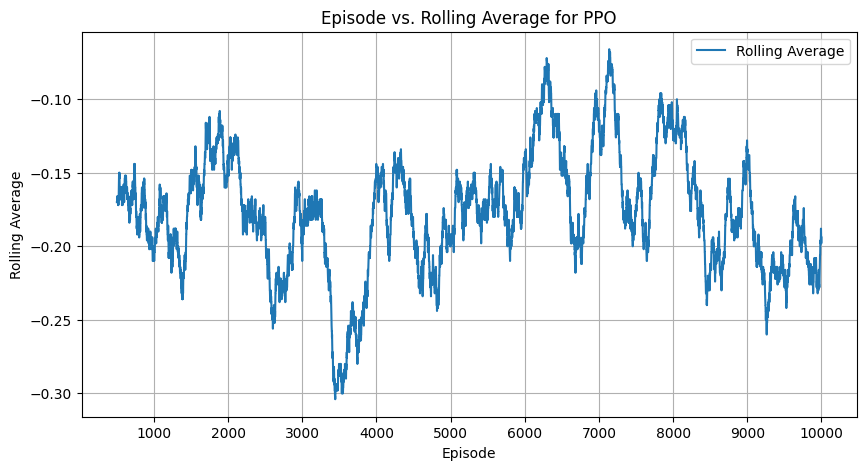

In [291]:
plot_rewards(ppo_rolling_avgs, 'Rolling Average', 'PPO')

###Comparison

####Episode vs Reward Comparison Graphs

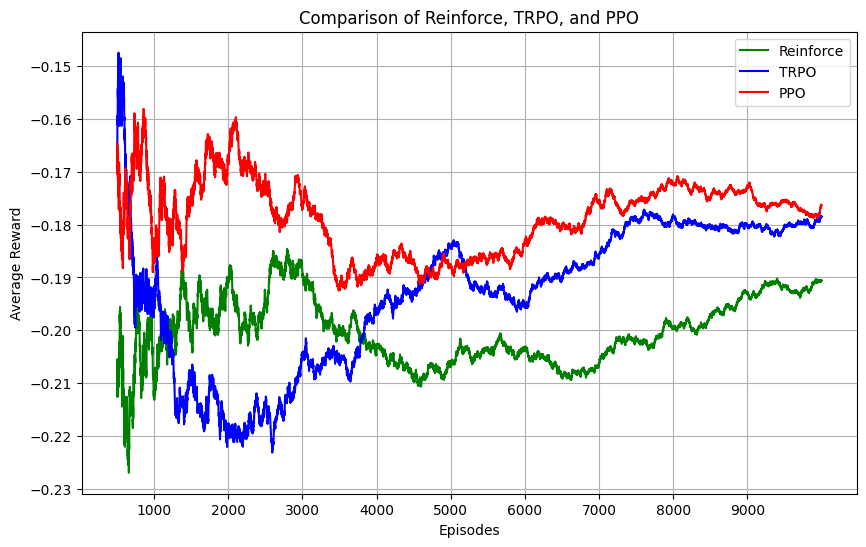

In [292]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Removing first 500 points to eliminate beginning phase on graph and plotting
plt.plot(range(500, 500 + len(reinforce_avg_rewards[500:])), reinforce_avg_rewards[500:], label='Reinforce', color='green')
plt.plot(range(500, 500 + len(trpo_avg_rewards[500:])), trpo_avg_rewards[500:], label='TRPO', color='blue')
plt.plot(range(500, 500 + len(ppo_avg_rewards[500:])), ppo_avg_rewards[500:], label='PPO', color='red')

# Labeling plot and setting ticks
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.title("Comparison of Reinforce, TRPO, and PPO")
xticks = range(1000, 500 + len(reinforce_avg_rewards[500:]), 1000)
plt.xticks(xticks)

plt.legend()
plt.grid()
plt.show()


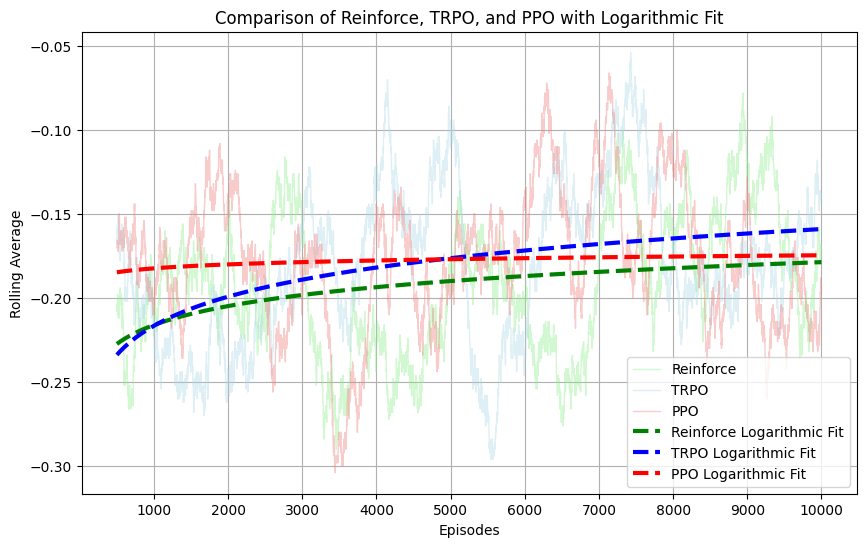

In [305]:
import numpy as np
import matplotlib.pyplot as plt

x_range = range(500, 500 + len(reinforce_rolling_avgs[500:])) # Setting x-range

def logarithmic_fit(x, y): # Fitting log function
    log_x = np.log(x)
    p = np.polyfit(log_x, y, 1)
    return p

#Fitting all of the models
p_reinforce = logarithmic_fit(x_range, reinforce_rolling_avgs[500:])
fitted_reinforce = np.polyval(p_reinforce, np.log(x_range))

p_trpo = logarithmic_fit(x_range, trpo_rolling_avgs[500:])
fitted_trpo = np.polyval(p_trpo, np.log(x_range))

p_ppo = logarithmic_fit(x_range, ppo_rolling_avgs[500:])
fitted_ppo = np.polyval(p_ppo, np.log(x_range))

plt.figure(figsize=(10, 6))

# Plotting rolling averages in the background with a lighter color
plt.plot(x_range, reinforce_rolling_avgs[500:], label='Reinforce', color='lightgreen', alpha=0.4, linewidth=1)
plt.plot(x_range, trpo_rolling_avgs[500:], label='TRPO', color='lightblue', alpha=0.4, linewidth=1)
plt.plot(x_range, ppo_rolling_avgs[500:], label='PPO', color='lightcoral', alpha=0.4, linewidth=1)

# Plotting the logarithmic regression lines with bolder colors
plt.plot(x_range, fitted_reinforce, '--', label='Reinforce Logarithmic Fit', color='green', linewidth=3)
plt.plot(x_range, fitted_trpo, '--', label='TRPO Logarithmic Fit', color='blue', linewidth=3)
plt.plot(x_range, fitted_ppo, '--', label='PPO Logarithmic Fit', color='red', linewidth=3)

# Labeling and setting ticks
plt.xlabel("Episodes")
plt.ylabel("Rolling Average")
plt.title("Comparison of Reinforce, TRPO, and PPO with Logarithmic Fit")
xticks = range(1000, 500 + len(reinforce_rolling_avgs[100:]), 1000)
plt.xticks(xticks)

plt.legend()
plt.grid()
plt.show()


####AUC Comparison

*See comparison at bottom of the notebook*

##Problem 4: Algorithm Comparison and Analysis

####Question 1

Here are the total areas under the curve for each algorithm, with TRPO and PPO having the best performance:

Text(0.5, 1.0, 'Total Rewards for Each Algorithm in Naïve Blackjack')

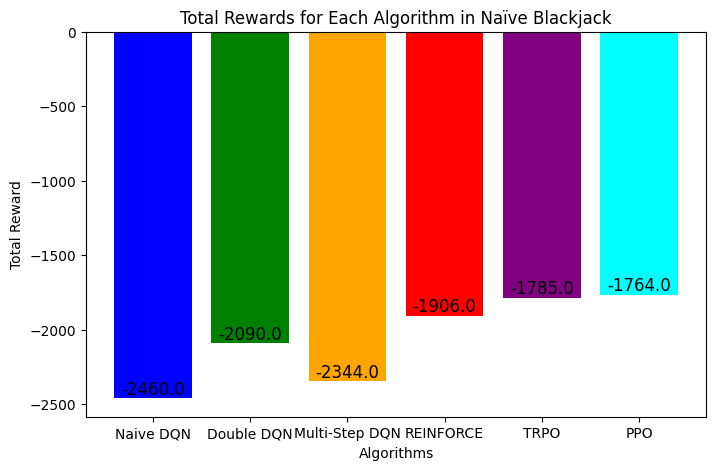

In [296]:
algorithms = ["Naive DQN", "Double DQN", "Multi-Step DQN", "REINFORCE", "TRPO", "PPO"]
reward_sums = [sum(ndqn_rewards), sum(ddqn_rewards), sum(multi_dqn_rewards),
           sum(reinforce_rewards), sum(trpo_rewards), sum(ppo_rewards)]

plt.figure(figsize=(8, 5))
bars = plt.bar(algorithms, reward_sums, color=['blue', 'green', 'orange', 'red', 'purple', 'cyan'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, str(yval), ha='center', va='bottom', fontsize=12)

plt.xlabel("Algorithms")
plt.ylabel("Total Reward")
plt.title("Total Rewards for Each Algorithm in Naïve Blackjack")

**DQN Variants AUC Comparison:**

Among the DQN variants, the double dqn had the highest performance. It had the highest total reward, which could be do to the fact that by using an objective and target function the variance is reduced. The multi-step dqn function is the next best, because it considers other rewards outside of the current timestep. Naive DQN is last, but this is to be expected due to the higher variance and the fact that is doesn't consider other rewards.

**Policy Gradient Methods AUC Comparison**

The PPO model did the best with the TRPO model being very close in performance. The REINFORCE model was the worst of the three, but better than the DQN variants. I think this is because the REINFORCE model has too much instability and variance during training, making it hard to achieve higher performance. While the TRPO and PPO models are designed for more complex environments, they handled the Blackjack environment quite well. The PPO was slightly better, which I think is due to the fact that is simplifies the TRPO model.

Here are the variances of the rolling averages for each algorithm:

In [300]:
import numpy as np

all_rolling_avgs = [ndqn_rolling_avgs, ddqn_rolling_avgs, multi_dqn_rolling_avgs,
                    reinforce_rolling_avgs, trpo_rolling_avgs, ppo_rolling_avgs]

for i, rolling_avg in enumerate(all_rolling_avgs):
    print(f"Algorithm {algorithms[i]}: Variance = {np.var(rolling_avg)}")

Algorithm Naive DQN: Variance = 0.002666295076494171
Algorithm Double DQN: Variance = 0.005009616969368412
Algorithm Multi-Step DQN: Variance = 0.004040295459415958
Algorithm REINFORCE: Variance = 0.002181306227543253
Algorithm TRPO: Variance = 0.002432050767409496
Algorithm PPO: Variance = 0.00203218070818098


As we can see from the statistics, REINFORCE and PPO had the lowest variances, with Double DQN and Multi-Step DQN having the highest variances. This is surprising because usually the flaw of reinforce is the high variance in its gradients, but due to the simple environment of blackjack was successful.

From both the AUC and the variance, we can see that the PPO algorithm was the most successful, since it had the lowest variance and highest total rewards. The Naive DQN model was stable, but produced the lowest rewards. While the Double DQN and Multi Step DQN models had higher variance, they did perform better overall, with the Double DQN model showing the best performance amongst the DQN variants. Lastly, the Reinforce and TRPO models were also both successful, with Reinforce having the edge on TRPO in variance, but TRPO peforming better overall.

####Question 2

Question 2 is provided throughout the notebook, after optimal hyperparameters have been selected

####Question 3

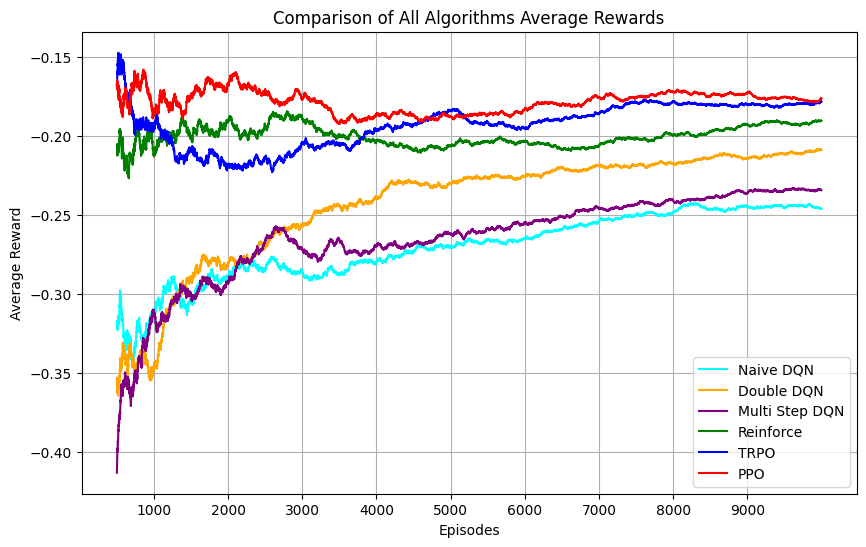

In [308]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Removing first 500 points to eliminate beginning phase on graph and plotting
plt.plot(range(500, 500 + len(ndqn_avg_rewards[500:])), ndqn_avg_rewards[500:], label='Naive DQN', color='cyan')
plt.plot(range(500, 500 + len(ddqn_avg_rewards[500:])), ddqn_avg_rewards[500:], label='Double DQN', color='orange')
plt.plot(range(500, 500 + len(multi_dqn_avg_rewards[500:])), multi_dqn_avg_rewards[500:], label='Multi Step DQN', color='purple')
plt.plot(range(500, 500 + len(reinforce_avg_rewards[500:])), reinforce_avg_rewards[500:], label='Reinforce', color='green')
plt.plot(range(500, 500 + len(trpo_avg_rewards[500:])), trpo_avg_rewards[500:], label='TRPO', color='blue')
plt.plot(range(500, 500 + len(ppo_avg_rewards[500:])), ppo_avg_rewards[500:], label='PPO', color='red')

# Labeling plot and setting ticks
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.title("Comparison of All Algorithms Average Rewards")
xticks = range(1000, 500 + len(reinforce_avg_rewards[500:]), 1000)
plt.xticks(xticks)

plt.legend()
plt.grid()
plt.show()


The graph shows us the that REINFORCE, TRPO, and PPO algorithms had better success than the DQN variations. What is also interesting about the graph is that the DQN algorithms seemed to grow better over timing, starting off poorly, whereas the other algorithms stayed more constant as they converged.

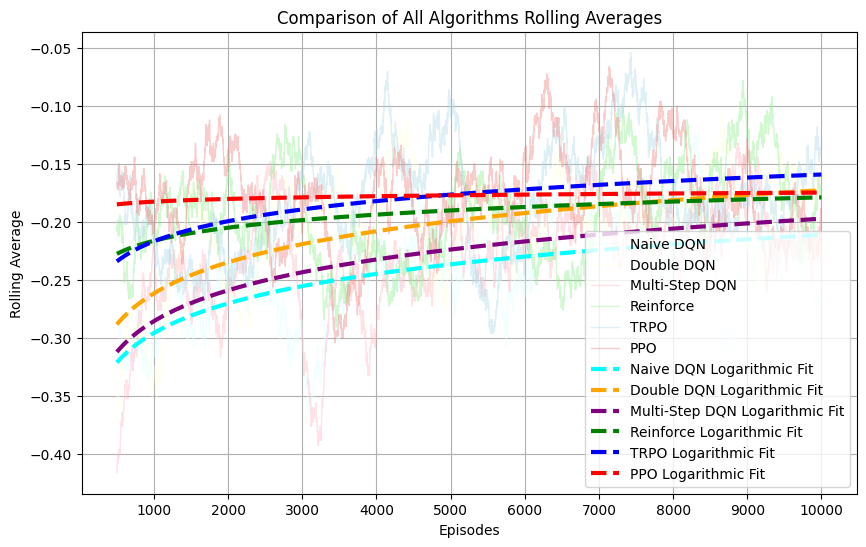

In [307]:
import numpy as np
import matplotlib.pyplot as plt

x_range = range(500, 500 + len(reinforce_rolling_avgs[500:])) # Setting x-range

def logarithmic_fit(x, y): # Fitting log function
    log_x = np.log(x)
    p = np.polyfit(log_x, y, 1)
    return p

#Fitting all of the models
p_ndqn = logarithmic_fit(x_range, ndqn_rolling_avgs[500:])
fitted_ndqn = np.polyval(p_ndqn, np.log(x_range))

p_ddqn = logarithmic_fit(x_range, ddqn_rolling_avgs[500:])
fitted_ddqn = np.polyval(p_ddqn, np.log(x_range))

p_multi_dqn = logarithmic_fit(x_range, multi_dqn_rolling_avgs[500:])
fitted_multi_dqn = np.polyval(p_multi_dqn, np.log(x_range))

p_reinforce = logarithmic_fit(x_range, reinforce_rolling_avgs[500:])
fitted_reinforce = np.polyval(p_reinforce, np.log(x_range))

p_trpo = logarithmic_fit(x_range, trpo_rolling_avgs[500:])
fitted_trpo = np.polyval(p_trpo, np.log(x_range))

p_ppo = logarithmic_fit(x_range, ppo_rolling_avgs[500:])
fitted_ppo = np.polyval(p_ppo, np.log(x_range))

plt.figure(figsize=(10, 6))

# Plotting rolling averages in the background with a lighter color
plt.plot(x_range, ndqn_rolling_avgs[500:], label='Naive DQN', color='lightcyan', alpha=0.4, linewidth=1)
plt.plot(x_range, ddqn_rolling_avgs[500:], label='Double DQN', color='lightyellow', alpha=0.4, linewidth=1)
plt.plot(x_range, multi_dqn_rolling_avgs[500:], label='Multi-Step DQN', color='lightpink', alpha=0.4, linewidth=1)
plt.plot(x_range, reinforce_rolling_avgs[500:], label='Reinforce', color='lightgreen', alpha=0.4, linewidth=1)
plt.plot(x_range, trpo_rolling_avgs[500:], label='TRPO', color='lightblue', alpha=0.4, linewidth=1)
plt.plot(x_range, ppo_rolling_avgs[500:], label='PPO', color='lightcoral', alpha=0.4, linewidth=1)

# Plotting the logarithmic regression lines with bolder colors
plt.plot(x_range, fitted_ndqn, '--', label='Naive DQN Logarithmic Fit', color='cyan', linewidth=3)
plt.plot(x_range, fitted_ddqn, '--', label='Double DQN Logarithmic Fit', color='orange', linewidth=3)
plt.plot(x_range, fitted_multi_dqn, '--', label='Multi-Step DQN Logarithmic Fit', color='purple', linewidth=3)
plt.plot(x_range, fitted_reinforce, '--', label='Reinforce Logarithmic Fit', color='green', linewidth=3)
plt.plot(x_range, fitted_trpo, '--', label='TRPO Logarithmic Fit', color='blue', linewidth=3)
plt.plot(x_range, fitted_ppo, '--', label='PPO Logarithmic Fit', color='red', linewidth=3)

# Labeling and setting ticks
plt.xlabel("Episodes")
plt.ylabel("Rolling Average")
plt.title("Comparison of All Algorithms Rolling Averages")
xticks = range(1000, 500 + len(reinforce_rolling_avgs[100:]), 1000)
plt.xticks(xticks)

plt.legend()
plt.grid()
plt.show()


While the rolling average graphs themselves vary a lot, we can use a logarithmic fit to see that most of the algorithms seem to be converging to the same place in terms of the rolling average rewards. To no surprise, the algorithms that performed better are converging to a higher value than those who performed worse. But, it is important to note that the PPO curve seems to be roughly flat, while the TRPO curve is slightly increasing. This could show signs that with more interations, the TRPO algorithm could be more successful.

####Question 4

**Naive DQN:**

Strengths - The simplicity of this algorithmis effective for Blackjack since it has a discrete and small aciton space. Experience replay also helps the learning process.

Weaknesses - In situations that require long term planning in the Blackjack environment, this algorithm won't work very well. So, it may not find the optimal policy if it is best to hit many times.

**Double DQN:**

Strengths - Improves on Naive DQN. Since we have a network to select an action and a target network to evaluate it, we don't overestimate Q as often

Weaknesses - Takes much longer to run since it is more complex. In this case, not too bad since the environment is simple, but it still look some time to find optimal hyperparameters due to repeaed training.

**Multi Step DQN:**

Strengths - Since we are now considering more rewards at each timestep, learning should be faster since in Blackjack you only get the reward at the end of the game. In the graph we can see the performance start off poor (as a model normally does) but immediately show significant improvements after the initial episodes.  

Weaknesses - Choosing the hyperparameters is a lot more difficult, especially the number of steps. It also has a slower runtime than Naive DQN, and also surprisingly showed more variance.

**REINFORCE:**

Strengths - We can directly optimize the policy without needing a value function, which is good for an environment like Blackjack where the rewards are only given at the end.

Weaknesses - There's high variance estimating the gradient, so sometimes the model didn't converge.

**TRPO:**

Strengths - Since our update step is constrained by kl divergence, the algortihm is more stable.

Weaknesses - While in our case it was successful, it works well in more complex environments, so this could lead to error sometimes in the blackjack environment. It also is harder to tune and takes longer to run than Reinforce.

**PPO:**

Strengths - Since TRPO is slightly too complex for our environment, PPO is good at simplifying it to work for our discrete action space - this come from the gradient clipping. It is more stable and learns quickly at the same time.

Weaknesses - It is still hard to tune, especially due to the added hyperparameter. Also, there is a lot of variance in Blackjack due to the random drawings, so this variance can affect the model.
